## Project 4:  Solving N-Queens Problem using Genetic Algorithms

#### CSC 180  Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento


In [1]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
# Project 4: Due 4/23
#
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239


## Part I: Position-index-based board representation

In [2]:
import random
import math
import numpy as np
# run 'pip install deap'
from deap import algorithms, base, creator, tools
board_size = 8
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [3]:
def create_individual():
    return random.sample(range(board_size * board_size), board_size)

In [4]:
print(create_individual())

[10, 41, 36, 0, 37, 25, 52, 20]


In [5]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0]*(board_size * board_size)
    for i in board:
        n[i] = 1
    
    count = 0
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print(dashes)
            


In [6]:
toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
pop = toolbox.population(n=1000)

print(pop[0])

[1, 8, 52, 50, 37, 21, 63, 54]


In [8]:
show_grid(pop[0], board_size)

-|X|-|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|X|-|X|-|X|-|
----------------
-|-|-|-|-|-|-|X|
----------------


### 10 pts:  Write your code in the cell below to define the "eval_fitness" function, which returns the fitness of any given board.  

- Noticed that in this case, mutation may generate invalid board, e.g., the board with dupliciate positions.  Think about   [5, 32, 8, 8, 41, 3, 55, 49]

- How to exclude those invalid boards from each generation? One way is to add some penalty to the fitness value of invalid boards.  In that case, any invalid board will have a very high fitness value (remember that our goal is to find the board with least fitness value).    To do that, let's write a function ***checkDuplicate()*** to calculate the number of queen pairs in the same position for any given board.   ***Give each duplicate a high penalty (i.e., multiply by 20, 50) and add the penalty to the fitness value.*** 

-  eval_fitness() returns the total number of duplicate position pair (with penalty) plus the total number of distinct pairs of queens that attack each other.  

In [9]:
# Calculate the number of queen pairs in the same position for any given board
def check_duplicate(individual):
    dup = 0
    individual_sorted = sorted(individual)
    duplicates=[]
    for i in individual_sorted:
     if individual_sorted.count(i)>1:
         if i not in duplicates:
             duplicates.append(i)
    dup = len(duplicates)
    
    return dup



## eval_fitness()
For a 1D array representing a board with some N queens, the following is done to check for collisions: first an empty dictionary is created. The dictionary is used to keep track of pair mappings in which an integer key maps to a tuple, representing that collision. Then, we check for a vertical, horizontal, and diagonal collision. A helper method unique_tuples() is given this dictionary, and computes a list of distinct conflicts. The size of this list is the number of distinct conflicts found for this board.

In [10]:
def unique_tuples(d):
    unique = []
    for key in d:
        reverse = ()
        item = d[key]
        for i in reversed(item):
            reverse += (i,)
        if item not in unique and reverse not in unique:
            unique.append(item)
    print(unique)
    return unique

def check_diag_right(i, j, board_size):
    n_upper = board_size + 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in right_edge:
        right = i
        if (right + n_upper) == j:
            return True
    
    if i not in left_edge:
        left = i
        if (left - n_upper) == j:
            return True
    
    if j not in right_edge:
        right = j
        if (right + n_upper) == i:
            return True
    
    if j not in left_edge:
        left = j
        if (left - n_upper) == i:
            return True
    # if i > j scan i to the left else scan j to the left
    for l in range(board_size):
        if i > j:
            if i not in left_edge:
                i -= n_upper
                if i == j:
                    return True
            if j not in right_edge:
                j += n_upper
                if j == i:
                    return True
        else:
            if j not in left_edge:
                j -= n_upper
                if j == i:
                    return True
            if i not in right_edge:
                i += n_upper
                if i == j:
                    return True
    return False

def check_diag_left(i, j, board_size):
    n_lower = board_size - 1
    right_edge = []
    left_edge = []
    
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in left_edge:
        right = i
        if (right + n_lower) == j:
            return True
    
    if i not in right_edge:
        left = i
        if (left - n_lower) == j:
            return True
    
    if j not in left_edge:
        right = j
        if (right + n_lower) == i:
            return True
    
    if j not in right_edge:
        left = j
        if (left - n_lower) == i:
            return True
    
    # if i > j scan i to the right else scan j to the right
    for l in range(board_size):
        if i > j:
            if i not in right_edge:
                i -= n_lower
                if i == j:
                    return True
            if j not in left_edge:
                j += n_lower
                if j == i:
                    return True
        else:
            if j not in right_edge:
                j -= n_lower
                if j == i:
                    return True
            if i not in left_edge:
                i += n_lower
                if i == j:
                    return True
    return False

def eval_fitness(individual):
    key = 0
    pairs = {}
    n_lower = board_size - 1
    
    for i in individual: 
        for j in individual:
            if i == j:
                continue
            if (i - j) % board_size == 0:
                key += 1
                pairs[key] = (i, j)
            if (math.floor(i / board_size)) == (math.floor(j / board_size)):
                key += 1
                pairs[key] = (i, j)
            if check_diag_right(i, j, board_size): 
                key += 1
                pairs[key] = (i, j)
            if check_diag_left(i, j, board_size):
                key += 1
                pairs[key] = (i, j)
    
    unique = unique_tuples(pairs)
    return ((50*check_duplicate(individual)) + len(unique),)

In [11]:
#list1 = [0, 10, 22, 31, 39, 44, 49, 62]
#list2 = [7, 13, 18, 28, 35, 41, 51, 61]
#list3 = [3, 9, 22, 24, 37, 47, 50, 57]
#list4 = [7, 11, 17, 28, 37, 41, 51, 61]
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))
#Should print:
# [(22, 31), (22, 62), (31, 39), (44, 62)]
# (4,)
# [(7, 28), (7, 35), (13, 41), (13, 61), (28, 35), (35, 51)]
# (6,)
# [(3, 24), (9, 57), (22, 50), (22, 57), (50, 57)]
# (5,)
# [(7, 28), (11, 51), (17, 41), (28, 37), (37, 51), (37, 61)]
# (6,)

In [12]:
show_grid(pop[0], board_size)
print(eval_fitness(pop[0]))

-|X|-|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|X|-|X|-|X|-|
----------------
-|-|-|-|-|-|-|X|
----------------
[(1, 8), (1, 37), (52, 50), (52, 54), (50, 54), (37, 21), (63, 54)]
(7,)


In [13]:
print(check_duplicate(pop[0]))

0


### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [14]:

toolbox.register("evaluate", eval_fitness)


In [15]:
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = (board_size * board_size), indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)

In [16]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

In [17]:
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change.

#### The *simple evolutionary algorithm* takes 5 arguments, a population, a toolbox, a probability of cross-overing two individuals (`cxpb`), a probability of mutating each individual (`mutpb`) and a number of generations to accomplish (`ngen`). 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)

[(21, 53), (21, 5), (21, 56), (21, 23), (21, 28), (26, 53), (26, 5), (26, 28), (53, 5), (5, 23), (56, 63), (56, 28), (23, 63)]
[(16, 19), (28, 27), (28, 19), (27, 41), (27, 13), (27, 51), (27, 19), (41, 57), (41, 13), (51, 19)]
[(17, 21), (37, 55), (37, 21), (37, 29), (52, 55), (21, 29), (29, 2)]
[(38, 22), (38, 35), (22, 17), (22, 21), (58, 10), (17, 21), (17, 35), (17, 1), (17, 10), (21, 35), (1, 10)]
[(2, 7), (2, 47), (2, 11), (7, 47), (7, 15), (53, 44), (47, 44), (47, 15), (47, 11), (19, 11), (15, 11)]
[(38, 22), (0, 24), (0, 27), (0, 1), (49, 1), (22, 23), (24, 27)]
[(5, 2), (5, 26), (5, 7), (28, 25), (28, 26), (28, 7), (28, 36), (25, 26), (2, 26), (2, 7), (26, 62)]
[(42, 41), (42, 33), (48, 41), (48, 16), (48, 53), (5, 33), (5, 53), (41, 33)]
[(11, 14), (11, 29), (11, 12), (11, 43), (49, 14), (49, 55), (49, 58), (14, 12), (29, 43)]
[(4, 18), (4, 31), (18, 54), (18, 17), (18, 26), (54, 62), (62, 17), (62, 59), (62, 26), (17, 26), (59, 31), (31, 26)]
[(42, 44), (42, 26), (42, 41), 

[(58, 63), (58, 10), (28, 10), (28, 19), (28, 46), (17, 3), (17, 10), (17, 19), (3, 10), (3, 19), (10, 19), (10, 46), (19, 46)]
[(17, 22), (17, 16), (28, 42), (28, 52), (63, 15), (22, 15), (22, 16), (52, 16)]
[(55, 7), (55, 46), (43, 16), (43, 46), (43, 35), (56, 16), (56, 0), (56, 7), (56, 35), (16, 0), (0, 7), (7, 35)]
[(41, 25), (41, 34), (41, 42), (30, 25), (30, 58), (25, 4), (25, 34), (34, 42), (34, 58), (42, 58)]
[(14, 49), (14, 8), (14, 46), (49, 57), (8, 16), (20, 16)]
[(50, 48), (50, 42), (50, 51), (4, 31), (4, 11), (48, 51), (39, 31), (42, 51), (51, 11)]
[(43, 42), (43, 27), (43, 25), (43, 3), (27, 25), (27, 3), (27, 31), (25, 31), (53, 37)]
[(28, 4), (28, 1), (28, 24), (4, 1), (33, 1), (33, 24), (50, 48), (24, 48)]
[(36, 39), (1, 6), (53, 39), (40, 24), (40, 16), (24, 16)]
[(10, 12), (10, 58), (10, 28), (12, 28), (58, 57), (28, 31), (31, 38)]
[(55, 23), (55, 49), (36, 12), (36, 0), (6, 0)]
[(28, 4), (28, 30), (28, 55), (11, 4), (4, 5), (39, 30), (39, 34), (39, 55)]
[(18, 21)

[(61, 53), (61, 54), (61, 52), (53, 8), (53, 54), (53, 52), (14, 8), (14, 54), (14, 7), (54, 52), (7, 4), (52, 4)]
[(6, 13), (6, 2), (57, 60), (57, 29), (13, 29), (13, 45), (2, 29), (29, 45)]
[(40, 44), (40, 26), (40, 42), (36, 44), (36, 57), (36, 22), (36, 35), (44, 26), (44, 42), (44, 35), (26, 42), (26, 35), (42, 35), (57, 22)]
[(36, 28), (36, 57), (36, 18), (36, 54), (36, 43), (28, 26), (3, 43), (57, 43), (18, 54), (18, 26)]
[(43, 44), (43, 59), (43, 40), (18, 63), (18, 2), (53, 44), (63, 59), (44, 40)]
[(55, 19), (55, 37), (55, 31), (55, 46), (19, 37), (19, 22), (19, 46), (37, 30), (37, 29), (37, 46), (30, 31), (30, 22), (30, 29), (30, 46), (31, 22), (31, 29), (22, 29), (22, 46)]
[(37, 38), (37, 35), (37, 45), (2, 38), (38, 35), (38, 52), (38, 45), (35, 49), (52, 45), (52, 49), (52, 48), (49, 48)]
[(38, 6), (6, 7), (6, 13), (23, 7), (23, 63), (7, 63), (40, 24)]
[(32, 35), (32, 56), (35, 42), (35, 56), (35, 7), (20, 13), (42, 56), (42, 7), (56, 7), (13, 31), (7, 31)]
[(48, 52), (48

[(54, 55), (54, 51), (26, 5), (26, 12), (13, 5), (13, 12), (5, 12), (5, 23), (55, 51), (55, 23), (51, 23)]
[(3, 39), (13, 20), (13, 31), (20, 16), (20, 52), (20, 47), (31, 52), (31, 39), (31, 47), (16, 52), (39, 47)]
[(32, 40), (19, 22), (19, 20), (19, 55), (19, 40), (22, 20), (60, 20), (20, 47), (55, 47), (47, 40)]
[(1, 2), (14, 23), (14, 11), (14, 42), (14, 12), (40, 42), (40, 12), (2, 11), (2, 42), (11, 12)]
[(47, 41), (47, 43), (24, 30), (24, 25), (41, 43), (41, 1), (41, 25), (43, 25), (1, 5), (1, 25), (30, 25)]
[(41, 48), (14, 10), (14, 30), (29, 30), (29, 37), (48, 55), (55, 10), (55, 37), (10, 37), (30, 37)]
[(60, 12), (60, 56), (60, 46), (12, 11), (12, 5), (56, 49), (43, 11), (43, 46)]
[(5, 23), (5, 61), (48, 54), (48, 50), (48, 41), (54, 50), (54, 61), (10, 50), (50, 41)]
[(11, 38), (11, 43), (49, 40), (49, 52), (40, 43), (38, 52), (38, 62), (43, 52), (43, 61), (52, 61), (61, 62)]
[(48, 27), (48, 53), (48, 56), (27, 28), (46, 28), (46, 53), (28, 56)]
[(43, 15), (43, 41), (43, 

[(3, 12), (3, 21), (14, 54), (14, 12), (14, 21), (36, 54), (36, 12), (36, 32), (54, 53), (12, 21), (53, 21)]
[(45, 27), (45, 18), (1, 2), (2, 18), (2, 11), (27, 18), (27, 11), (15, 11), (18, 11)]
[(27, 63), (27, 9), (27, 35), (27, 3), (27, 18), (63, 9), (63, 7), (63, 18), (9, 12), (9, 18), (35, 3), (35, 7), (3, 7), (3, 12)]
[(52, 55), (52, 53), (56, 0), (56, 63), (0, 5), (0, 63), (55, 53), (55, 63), (53, 5)]
[(28, 31), (28, 25), (48, 57), (48, 51), (18, 45), (18, 25), (45, 31), (31, 25), (57, 25)]
[(10, 13), (10, 58), (10, 2), (57, 58), (57, 56), (58, 2), (58, 56), (2, 16), (16, 56)]
[(36, 63), (36, 15), (24, 40), (14, 15), (14, 46), (63, 15), (63, 55), (15, 55), (55, 46), (46, 40)]
[(17, 18), (17, 25), (17, 8), (17, 26), (18, 36), (18, 25), (18, 26), (36, 29), (25, 29), (25, 26), (8, 26), (29, 26)]
[(34, 43), (34, 38), (34, 32), (30, 38), (30, 44), (30, 24), (43, 44), (0, 32), (0, 24), (38, 32), (32, 24)]
[(38, 32), (38, 29), (4, 32), (17, 8), (32, 8)]
[(0, 32), (0, 6), (39, 37), (39,

[(42, 35), (42, 60), (3, 35), (3, 59), (35, 59), (57, 59), (57, 9), (57, 60), (59, 60)]
[(37, 33), (37, 34), (37, 35), (33, 34), (33, 41), (33, 35), (56, 35), (34, 41), (34, 35), (34, 20), (41, 20)]
[(32, 36), (26, 12), (36, 57), (36, 45), (36, 12), (36, 54), (45, 54)]
[(39, 32), (39, 36), (58, 62), (32, 41), (32, 36), (41, 43), (41, 9), (43, 36), (36, 9)]
[(56, 59), (56, 58), (56, 62), (56, 16), (56, 63), (56, 7), (59, 58), (59, 62), (59, 27), (59, 63), (58, 62), (58, 63), (62, 63), (27, 63), (63, 7)]
[(6, 34), (17, 23), (17, 49), (23, 55), (28, 49), (28, 55), (50, 49), (50, 34), (50, 55), (49, 55)]
[(36, 43), (36, 33), (36, 45), (43, 25), (43, 45), (14, 6), (33, 25), (6, 48)]
[(45, 52), (45, 5), (45, 18), (52, 20), (20, 11), (20, 18), (5, 33), (5, 14), (11, 18), (11, 14)]
[(53, 49), (3, 43), (3, 24), (3, 4), (49, 41), (16, 43), (16, 24), (43, 41)]
[(6, 30), (6, 0), (55, 37), (8, 40), (8, 0), (40, 58), (40, 0), (30, 37), (30, 58), (37, 58)]
[(7, 1), (7, 39), (7, 0), (32, 8), (32, 39),

[(41, 59), (41, 40), (29, 28), (29, 53), (59, 52), (59, 62), (28, 52), (53, 52), (53, 62)]
[(19, 33), (19, 55), (19, 27), (19, 37), (19, 1), (19, 18), (19, 59), (33, 37), (33, 1), (55, 37), (55, 1), (27, 18), (27, 59), (37, 1)]
[(15, 12), (15, 7), (15, 23), (52, 12), (52, 59), (7, 23), (23, 17), (17, 24)]
[(12, 20), (12, 30), (49, 50), (45, 0), (45, 43), (50, 43)]
[(10, 42), (10, 50), (10, 17), (41, 42), (41, 50), (41, 17), (22, 21), (22, 50), (22, 17), (21, 35), (21, 42), (21, 17), (35, 42), (35, 17), (42, 50)]
[(20, 21), (33, 1), (33, 9), (33, 57), (1, 9), (1, 57), (1, 55), (9, 57), (59, 57)]
[(1, 57), (44, 51), (44, 23), (44, 35), (32, 59), (32, 35), (51, 23), (51, 59), (51, 35), (57, 59), (59, 35)]
[(13, 9), (13, 27), (13, 14), (13, 31), (9, 27), (9, 14), (9, 36), (27, 36), (27, 51), (27, 31), (14, 7), (31, 7)]
[(47, 40), (47, 55), (47, 2), (0, 40), (0, 2), (0, 8), (0, 3), (40, 58), (40, 8), (58, 2), (2, 3)]
[(38, 31), (38, 62), (38, 6), (49, 42), (49, 17), (4, 31), (4, 6), (62, 17

[(30, 54), (53, 54), (2, 7), (2, 11), (2, 16), (11, 19), (19, 16)]
[(35, 8), (35, 11), (35, 56), (8, 11), (8, 56), (47, 11), (47, 55)]
[(50, 10), (50, 2), (50, 55), (10, 2), (10, 55), (44, 4), (2, 4), (31, 4), (31, 55), (31, 27)]
[(58, 18), (58, 56), (58, 50), (52, 31), (52, 50), (18, 50), (56, 35), (56, 7), (35, 7), (31, 7)]
[(2, 6), (35, 28), (35, 33), (35, 36), (35, 21), (28, 36), (28, 21), (33, 36), (33, 41), (6, 41)]
[(51, 27), (51, 49), (31, 27), (27, 34), (34, 10), (21, 49), (21, 14), (10, 14), (49, 14)]
[(23, 14), (23, 19), (23, 37), (14, 49), (14, 10), (19, 37), (19, 1), (19, 10), (29, 37), (37, 1), (37, 10), (1, 49), (1, 10)]
[(62, 55), (62, 14), (55, 28), (55, 31), (14, 28), (14, 5), (33, 5), (28, 31)]
[(53, 52), (53, 37), (53, 61), (19, 37), (52, 34), (52, 61), (34, 37), (34, 2), (34, 61), (57, 61), (37, 61)]
[(1, 17), (1, 33), (60, 33), (17, 33), (17, 23), (17, 18), (47, 29), (47, 23), (23, 18)]
[(40, 45), (34, 61), (30, 62), (62, 61), (61, 45)]
[(41, 34), (41, 44), (34, 3

[(23, 30), (23, 63), (23, 47), (63, 0), (63, 47), (52, 53), (42, 47)]
[(34, 52), (34, 27), (56, 62), (56, 8), (52, 53), (17, 62), (17, 8), (17, 53), (62, 8), (62, 53), (8, 53)]
[(50, 36), (50, 53), (50, 41), (50, 51), (36, 37), (53, 37), (53, 51), (30, 37), (30, 51), (37, 51)]
[(36, 34), (36, 39), (1, 41), (41, 34), (62, 30), (30, 39), (34, 39), (34, 16)]
[(10, 3), (10, 24), (10, 17), (57, 17), (3, 39), (3, 24), (3, 17), (53, 39), (53, 17), (40, 24), (24, 17)]
[(7, 49), (7, 55), (49, 57), (49, 55), (49, 52), (57, 60), (57, 22), (55, 52), (60, 52), (52, 16), (16, 22)]
[(19, 33), (19, 11), (19, 16), (54, 49), (29, 11), (33, 49), (49, 7)]
[(44, 17), (44, 8), (44, 46), (44, 20), (17, 49), (17, 8), (17, 20), (17, 57), (49, 57), (57, 59)]
[(14, 23), (14, 54), (14, 35), (31, 23), (23, 19), (23, 16), (34, 35), (34, 16), (35, 19), (19, 16)]
[(52, 38), (24, 17), (5, 21), (5, 13), (21, 22), (21, 13), (21, 17), (22, 38), (22, 13), (22, 17)]
[(19, 22), (19, 11), (25, 11), (56, 63), (56, 60), (56, 0

[(47, 20), (47, 42), (49, 21), (49, 56), (49, 42), (37, 21), (59, 56), (20, 21), (21, 56), (21, 42), (56, 42)]
[(43, 44), (43, 61), (43, 27), (43, 50), (31, 27), (0, 27)]
[(55, 49), (36, 12), (36, 0), (8, 12), (8, 0), (6, 0)]
[(34, 58), (34, 43), (7, 23), (7, 21), (7, 55), (23, 58), (23, 21), (23, 22), (23, 55), (43, 22), (21, 22)]
[(6, 48), (6, 38), (6, 30), (12, 11), (12, 30), (23, 30), (25, 11), (25, 30), (38, 11), (38, 30)]
[(40, 5), (40, 48), (37, 5), (37, 21), (5, 21)]
[(39, 53), (18, 9), (18, 19), (19, 43)]
[(21, 7), (21, 18), (21, 5), (6, 46), (6, 7), (6, 5), (7, 5), (18, 26), (26, 33), (26, 5), (33, 5)]
[(59, 38), (59, 43), (36, 38), (36, 43), (38, 46), (7, 5), (46, 43)]
[(20, 22), (20, 41), (20, 17), (20, 47), (22, 17), (63, 61), (63, 47), (41, 42), (41, 17), (41, 47), (42, 47), (61, 47)]
[(39, 36), (39, 55), (39, 15), (39, 3), (2, 10), (2, 11), (2, 3), (10, 55), (10, 11), (10, 15), (10, 3), (36, 15), (55, 15), (11, 15), (11, 3)]
[(10, 37), (10, 13), (37, 13), (27, 41), (27, 

[(61, 16), (61, 60), (6, 27), (27, 35), (35, 32), (16, 32)]
[(47, 63), (47, 44), (47, 40), (47, 7), (18, 63), (53, 44), (63, 59), (63, 7), (44, 40)]
[(43, 50), (43, 3), (38, 37), (38, 2), (50, 2), (17, 3), (3, 2)]
[(17, 3), (17, 26), (17, 57), (45, 36), (3, 51), (3, 39), (36, 57), (36, 39)]
[(32, 4), (32, 41), (32, 24), (4, 52), (52, 43), (41, 43), (26, 24)]
[(16, 40), (15, 50), (50, 58), (50, 42), (28, 42), (40, 58), (40, 42), (58, 42)]
[(17, 21), (17, 57), (37, 55), (37, 21), (37, 29), (52, 55), (21, 29), (57, 29), (29, 2)]
[(28, 26), (28, 29), (28, 37), (13, 29), (13, 37), (40, 26), (40, 58), (40, 43), (26, 29), (26, 58), (29, 37), (29, 43), (37, 58)]
[(23, 39), (4, 12), (38, 39), (8, 12), (8, 24), (39, 12)]
[(47, 7), (18, 17), (17, 3), (3, 7), (56, 7)]
[(6, 38), (6, 54), (6, 62), (38, 54), (38, 33), (38, 11), (38, 62), (50, 54), (54, 62), (33, 12), (11, 12)]
[(26, 50), (26, 5), (26, 17), (21, 56), (21, 5), (21, 17), (21, 39)]
[(38, 62), (38, 54), (38, 32), (48, 54), (48, 32), (48, 

[(19, 12), (19, 27), (30, 12), (30, 39), (30, 25), (30, 27), (8, 12), (12, 39), (39, 63), (25, 27), (27, 63)]
[(10, 58), (10, 15), (10, 50), (58, 51), (58, 30), (58, 50), (15, 50), (51, 52), (51, 30), (51, 50), (51, 48), (52, 50), (52, 48), (50, 48)]
[(44, 43), (44, 58), (43, 22), (13, 31), (13, 22), (54, 22), (31, 22)]
[(63, 9), (63, 61), (37, 61), (42, 49), (9, 49)]
[(47, 61), (47, 45), (47, 46), (36, 45), (36, 35), (36, 50), (51, 35), (51, 50), (61, 45), (45, 46)]
[(33, 17), (33, 40), (43, 40), (40, 58)]
[(35, 21), (35, 59), (35, 32), (35, 37), (20, 41), (20, 21), (41, 59), (41, 32), (21, 37), (58, 59), (58, 37), (59, 32), (32, 37)]
[(34, 27), (34, 43), (7, 21), (7, 55), (27, 43), (43, 22), (21, 22)]
[(15, 22), (53, 62), (53, 60), (53, 37), (62, 58), (62, 60), (62, 22), (58, 60), (58, 37)]
[(29, 31), (29, 53), (46, 53), (18, 0), (18, 16), (53, 51), (0, 16)]
[(52, 51), (62, 17), (62, 58), (51, 58), (51, 37), (40, 58), (58, 37)]
[(31, 4), (31, 26), (2, 4), (2, 26), (2, 20), (2, 9), (2

[(9, 41), (9, 63), (51, 37), (51, 53), (37, 53), (31, 63)]
[(9, 33), (9, 49), (9, 11), (48, 49), (33, 49), (22, 31)]
[(4, 2), (19, 40), (19, 17), (48, 40), (40, 42), (2, 38), (2, 42)]
[(15, 12), (33, 12), (33, 41), (33, 60), (56, 21), (56, 60), (12, 21), (12, 60), (21, 53), (60, 53)]
[(40, 19), (40, 56), (19, 27), (6, 38), (6, 27), (6, 4)]
[(43, 61), (43, 46), (43, 45), (43, 35), (43, 16), (61, 45), (61, 16), (46, 45), (46, 6)]
[(22, 4), (22, 13), (22, 21), (63, 47), (63, 9), (9, 13), (4, 13), (4, 32), (13, 21)]
[(13, 61), (13, 5), (3, 17), (3, 43), (3, 5), (61, 62), (61, 43), (61, 5), (62, 17)]
[(19, 33), (19, 46), (54, 49), (54, 53), (54, 36), (54, 46), (29, 53), (29, 36), (33, 49), (33, 36), (49, 53), (53, 46)]
[(22, 62), (22, 16), (52, 16)]
[(11, 27), (11, 38), (33, 38), (48, 27), (30, 62), (30, 27), (30, 38), (30, 46), (62, 38), (62, 46), (38, 46)]
[(24, 3), (24, 8), (3, 21), (58, 62), (58, 37), (62, 8), (37, 21)]
[(7, 4), (7, 55), (7, 2), (4, 36), (4, 12), (4, 2), (55, 46), (27, 

[(61, 43), (61, 25), (43, 25), (39, 38), (39, 33), (38, 33), (28, 25), (25, 33)]
[(61, 43), (61, 54), (43, 42), (39, 38), (38, 54), (42, 24), (42, 10), (24, 10)]
[(31, 55), (31, 28), (2, 20), (2, 9), (2, 0), (62, 55), (55, 28), (28, 20), (9, 0)]
[(43, 44), (43, 61), (43, 27), (43, 50), (31, 27), (0, 27)]
[(33, 49), (33, 57), (49, 57), (20, 2)]
[(37, 44), (37, 33), (37, 45), (44, 45), (45, 31), (22, 31)]
[(9, 57), (9, 2), (9, 41), (9, 15), (3, 2), (47, 2), (47, 41), (47, 15), (57, 41), (57, 15)]
[(55, 53), (55, 10), (33, 40), (29, 53), (59, 58), (10, 58), (40, 58)]
[(44, 41), (44, 43), (44, 20), (32, 41), (41, 6), (41, 43), (41, 20), (21, 20), (6, 20), (6, 15), (43, 15)]
[(36, 54), (36, 33), (36, 4), (24, 33), (14, 6), (14, 54), (6, 54), (6, 4)]
[(16, 2), (16, 32), (3, 2), (47, 2), (47, 41), (57, 41), (41, 32)]
[(13, 53), (51, 24), (51, 44), (51, 19), (51, 53), (39, 53), (44, 62), (44, 53), (62, 53)]
[(31, 13), (31, 23), (2, 20), (2, 9), (2, 16), (13, 20), (13, 9), (23, 20), (23, 16), (

[(63, 23), (63, 56), (63, 61), (6, 13), (6, 20), (10, 13), (13, 20), (13, 61), (20, 23), (56, 61)]
[(28, 56), (28, 49), (28, 4), (28, 7), (16, 56), (56, 49), (56, 7), (49, 41), (49, 7), (49, 53), (4, 7)]
[(51, 43), (51, 53), (51, 59), (10, 15), (43, 59), (43, 15), (20, 38), (38, 59)]
[(57, 49), (57, 36), (57, 63), (21, 49), (40, 49), (40, 24), (36, 63)]
[(17, 57), (59, 57), (55, 7), (55, 28), (7, 28), (28, 30)]
[(31, 52), (31, 23), (52, 20), (0, 9), (23, 20)]
[(40, 43), (40, 24), (43, 27), (27, 24), (27, 20), (27, 28), (24, 28), (20, 28), (28, 1)]
[(55, 53), (45, 53), (45, 27), (17, 8), (17, 53), (30, 27), (8, 53)]
[(34, 52), (34, 39), (34, 26), (34, 32), (56, 32), (39, 30), (39, 32), (30, 26)]
[(50, 36), (50, 41), (36, 33), (36, 39), (41, 33), (33, 39), (3, 39), (39, 23)]
[(25, 32), (2, 20), (2, 42), (51, 42), (51, 60), (20, 60), (42, 60)]
[(20, 22), (14, 22), (61, 58)]
[(36, 43), (36, 9), (36, 38), (36, 63), (43, 61), (9, 49), (9, 63), (61, 63)]
[(48, 32), (5, 4), (32, 4), (4, 31), (

[(24, 51), (24, 32), (61, 58), (51, 58)]
[(47, 20), (49, 28), (37, 28), (20, 4), (20, 28), (4, 28)]
[(14, 54), (14, 7), (14, 42), (53, 54), (54, 0), (54, 27), (2, 7), (2, 0), (2, 42), (7, 0), (7, 42), (0, 27)]
[(44, 23), (44, 53), (44, 26), (31, 23), (31, 38), (31, 26), (53, 26)]
[(57, 49), (57, 59), (57, 15), (21, 49), (21, 53), (40, 49), (40, 47), (49, 53), (47, 15)]
[(47, 20), (49, 50), (59, 27), (59, 50), (20, 27), (0, 27)]
[(27, 9), (27, 31), (9, 33), (5, 33), (47, 31), (47, 46), (47, 42), (33, 42), (46, 42)]
[(12, 30), (49, 41), (49, 51), (45, 0), (45, 41), (41, 34), (51, 30)]
[(18, 2), (1, 5), (1, 2), (5, 40), (5, 2), (5, 29), (40, 47), (40, 48), (2, 47), (2, 29), (47, 29)]
[(14, 23), (14, 54), (14, 11), (14, 42), (14, 12), (23, 31), (11, 12)]
[(47, 63), (47, 41), (47, 7), (47, 39), (16, 56), (56, 63), (56, 7), (63, 7), (63, 39), (6, 41), (6, 7), (7, 39)]
[(28, 49), (28, 52), (28, 29), (28, 35), (28, 4), (28, 19), (49, 52), (49, 35), (49, 53), (52, 4), (52, 53), (29, 53), (35, 1

[(48, 54), (48, 40), (54, 63), (28, 37), (63, 15), (37, 5), (40, 5)]
[(35, 39), (35, 26), (35, 11), (4, 60), (4, 11), (39, 30), (39, 60), (30, 26)]
[(6, 7), (29, 24), (55, 7), (55, 10), (24, 10), (24, 32), (32, 59)]
[(6, 13), (28, 49), (57, 17), (57, 49), (17, 23), (17, 49), (40, 49)]
[(36, 44), (36, 27), (36, 38), (36, 32), (36, 52), (44, 62), (44, 52), (25, 27), (25, 32), (25, 52), (38, 62), (38, 32), (38, 52)]
[(28, 52), (43, 61), (43, 22), (43, 52), (43, 15), (43, 16), (9, 15), (9, 16), (61, 52), (61, 16), (22, 15), (22, 16), (52, 16)]
[(17, 49), (17, 24), (28, 42), (28, 49), (28, 24), (42, 49), (42, 24)]
[(10, 2), (10, 14), (10, 11), (10, 46), (2, 11), (14, 11), (14, 46), (44, 46)]
[(2, 20), (2, 3), (31, 59), (31, 25), (59, 3), (59, 51), (3, 51)]
[(55, 52), (33, 40), (52, 61), (18, 11), (18, 58), (61, 58), (40, 58)]
[(6, 41), (6, 7), (41, 43), (21, 7)]
[(28, 56), (28, 4), (28, 7), (16, 56), (16, 8), (56, 63), (56, 7), (56, 8), (63, 7), (4, 7)]
[(13, 37), (13, 27), (13, 53), (50, 5

[(55, 39), (45, 5), (4, 5), (4, 32), (39, 32), (5, 26), (32, 56)]
[(9, 33), (9, 49), (9, 11), (48, 49), (33, 49), (22, 31)]
[(1, 7), (1, 41), (11, 32), (11, 13), (32, 41), (41, 13)]
[(63, 9), (63, 57), (53, 21), (53, 26), (21, 22), (9, 57), (22, 57), (40, 26)]
[(14, 42), (14, 46), (14, 54), (31, 4), (4, 20), (42, 46), (46, 54), (61, 54)]
[(24, 8), (24, 56), (24, 30), (8, 11), (8, 56), (47, 11), (47, 55)]
[(35, 14), (35, 51), (35, 32), (61, 58), (51, 58)]
[(43, 44), (43, 27), (43, 61), (31, 27), (61, 56)]
[(14, 38), (0, 27)]
[(37, 34), (37, 33), (37, 53), (31, 27), (31, 59), (34, 16), (34, 33), (34, 27), (27, 59)]
[(44, 47), (44, 41), (16, 2), (3, 2), (47, 2), (47, 41), (47, 15), (57, 41), (57, 15)]
[(58, 49), (3, 24), (8, 24), (46, 22), (46, 45)]
[(61, 29), (61, 57), (29, 30), (29, 57), (29, 11), (29, 28), (48, 57), (48, 55), (30, 28), (28, 55)]
[(55, 48), (55, 46), (45, 46), (48, 32), (48, 56), (46, 22), (32, 56)]
[(27, 11), (27, 3), (61, 37), (17, 3), (11, 38), (11, 3), (38, 37)]
[(6

[(35, 43), (35, 36), (35, 49), (35, 11), (43, 36), (43, 46), (43, 16), (43, 11), (2, 16), (2, 11)]
[(63, 9), (12, 9), (12, 20), (22, 6), (22, 20), (6, 20)]
[(30, 54), (53, 54), (2, 7), (2, 11), (2, 16), (11, 19), (19, 16)]
[(47, 40), (47, 2), (47, 41), (19, 40), (19, 27), (48, 40), (48, 41), (48, 27), (48, 8), (40, 41), (40, 8), (41, 27)]
[(15, 13), (15, 50), (13, 37), (13, 53), (50, 53), (37, 38), (37, 53), (60, 53)]
[(51, 44), (51, 24), (51, 49), (10, 1), (10, 14), (10, 24), (1, 49), (14, 22), (14, 49)]
[(20, 36), (43, 36), (36, 63), (36, 32), (63, 58)]
[(7, 55), (55, 51), (55, 46), (51, 58), (36, 20), (36, 57), (57, 58)]
[(14, 49), (14, 8), (49, 57), (8, 16)]
[(40, 44), (31, 23), (31, 4), (31, 59), (31, 27), (23, 44), (4, 44), (59, 27)]
[(14, 49), (14, 21), (14, 28), (49, 21), (49, 28), (49, 53), (49, 1), (21, 3), (21, 20), (21, 28), (21, 53), (3, 1), (20, 28), (28, 1)]
[(35, 49), (35, 32), (48, 57), (48, 49), (48, 32), (48, 16), (57, 49), (46, 10), (32, 16)]
[(62, 63), (29, 5), (5,

[(18, 45), (18, 22), (18, 23), (6, 22), (51, 33), (51, 23), (45, 29), (22, 23), (22, 29)]
[(37, 44), (44, 47), (44, 60), (31, 47), (47, 11)]
[(27, 11), (27, 3), (61, 16), (17, 16), (17, 3), (11, 38), (11, 3)]
[(29, 53), (29, 64), (18, 9), (18, 16), (9, 14), (9, 16), (53, 51), (64, 16)]
[(39, 60), (39, 46), (39, 53), (60, 46), (60, 53), (46, 53), (46, 6), (46, 43), (46, 64), (43, 64)]
[(16, 25), (15, 50), (15, 57), (50, 57), (50, 58), (50, 42), (25, 57), (57, 58), (58, 42)]
[(9, 27), (44, 28), (44, 53), (44, 37), (44, 20), (27, 3), (27, 28), (27, 20), (28, 37), (28, 20), (53, 37)]
[(58, 63), (58, 59), (58, 61), (58, 49), (63, 59), (63, 61), (63, 39), (59, 61), (20, 22)]
[(53, 61), (53, 26), (53, 45), (53, 55), (61, 45), (9, 45)]
[(28, 19), (28, 31), (28, 25), (48, 57), (48, 51), (39, 31), (19, 51), (31, 25), (57, 25)]
[(24, 8), (52, 61), (52, 43), (18, 22), (61, 43), (22, 43), (41, 43)]
[(4, 18), (4, 2), (18, 9), (18, 19), (18, 2), (9, 14), (9, 2)]
[(39, 38), (13, 6), (51, 43), (38, 6),

[(47, 61), (47, 11), (61, 53), (53, 49), (14, 49), (14, 11), (19, 11)]
[(23, 14), (23, 17), (23, 55), (8, 14), (8, 17), (8, 32), (8, 56), (14, 38), (14, 56), (38, 32), (32, 56)]
[(55, 15), (55, 39), (15, 39), (4, 60), (38, 39), (38, 34), (39, 34), (39, 60), (26, 34)]
[(55, 23), (55, 49), (36, 29), (36, 12), (36, 0)]
[(60, 56), (56, 35), (6, 5), (35, 19), (35, 17), (5, 19), (19, 17)]
[(63, 61), (63, 39), (4, 20), (26, 24)]
[(45, 27), (45, 53), (27, 30), (27, 11), (30, 58), (58, 2), (2, 11), (11, 32)]
[(28, 60), (28, 37), (28, 14), (28, 31), (60, 63), (63, 31)]
[(14, 42), (14, 46), (14, 11), (31, 4), (4, 20), (4, 11), (42, 46), (20, 11)]
[(49, 52), (49, 35), (52, 4), (52, 36), (29, 36), (35, 36), (35, 8), (4, 36)]
[(47, 39), (35, 19), (35, 39), (12, 13), (12, 19), (12, 39)]
[(44, 45), (44, 60), (32, 59), (1, 57), (1, 10), (57, 60), (57, 59), (45, 59), (60, 59)]
[(6, 20), (6, 15), (52, 53), (52, 20), (39, 53), (39, 15), (24, 10), (10, 15)]
[(24, 33), (24, 51), (24, 32), (33, 41), (33, 51)

[(35, 43), (35, 44), (48, 0), (43, 61), (43, 47), (43, 44), (1, 0), (61, 47), (47, 44)]
[(48, 57), (57, 17), (17, 3), (37, 5), (3, 12), (3, 5), (12, 5)]
[(7, 31), (7, 21), (7, 6), (31, 59), (59, 51), (21, 17), (6, 46)]
[(2, 20), (2, 0), (2, 50), (8, 0), (8, 14), (20, 19), (59, 50), (59, 19)]
[(24, 32), (24, 27), (9, 57), (9, 2), (9, 27), (47, 2)]
[(37, 1), (37, 44), (20, 44), (20, 22), (20, 41), (1, 41), (14, 22), (14, 15), (44, 41), (22, 15)]
[(55, 39), (55, 48), (55, 15), (45, 5), (4, 5), (39, 15), (48, 56)]
[(25, 30), (25, 26), (25, 32), (40, 26), (40, 32), (37, 30), (37, 32), (37, 21), (30, 26), (30, 21)]
[(7, 3), (7, 23), (50, 59), (3, 59), (3, 19), (38, 59), (59, 19), (23, 19)]
[(47, 61), (13, 61), (13, 8), (33, 36), (33, 49), (33, 51), (49, 51)]
[(30, 14), (20, 19), (20, 16), (64, 57), (64, 19), (64, 16), (61, 57), (61, 16), (19, 16)]
[(24, 51), (24, 32), (53, 54), (53, 51), (54, 51), (59, 51), (59, 32), (59, 58), (51, 58)]
[(7, 2), (7, 49), (2, 50), (49, 50), (59, 50), (59, 19)

[(41, 59), (36, 12), (23, 19), (23, 51), (23, 55), (19, 59), (19, 12), (19, 51), (19, 55), (59, 51), (51, 55)]
[(55, 46), (55, 49), (21, 49), (46, 44), (44, 26), (26, 24), (24, 0)]
[(63, 61), (61, 5), (32, 11), (32, 24), (11, 20)]
[(30, 54), (30, 39), (53, 54), (53, 39), (2, 7), (2, 16), (7, 39), (19, 16)]
[(9, 27), (48, 27), (48, 32), (48, 6), (29, 27), (29, 38), (29, 31), (27, 6), (27, 31), (38, 32), (38, 6), (38, 31)]
[(61, 25), (3, 17), (25, 33), (25, 17), (25, 49), (33, 17), (33, 49), (17, 23), (17, 49), (23, 55), (49, 55)]
[(47, 38), (47, 7), (38, 37)]
[(13, 37), (13, 8), (56, 8)]
[(25, 17), (25, 32), (2, 6), (21, 17), (21, 13), (6, 13)]
[(2, 20), (2, 42), (31, 59), (31, 15), (59, 51), (42, 51), (42, 46)]
[(2, 20), (2, 3), (31, 59), (31, 25), (59, 3), (59, 51), (3, 51)]
[(37, 61), (37, 33), (37, 38), (37, 23), (37, 19), (52, 61), (52, 38), (52, 59), (61, 59), (33, 38), (33, 19), (38, 59), (59, 19), (23, 19)]
[(7, 3), (7, 47), (7, 2), (7, 15), (8, 15), (3, 2), (47, 2), (47, 41), (

[(47, 38), (47, 23), (13, 27), (25, 27), (25, 49)]
[(36, 44), (36, 50), (36, 37), (36, 0), (36, 27), (44, 37), (44, 8), (3, 0), (3, 27), (0, 27), (0, 8)]
[(63, 45), (63, 39), (4, 32), (39, 30), (39, 32), (30, 26)]
[(1, 49), (1, 4), (1, 37), (61, 37), (61, 56), (49, 56), (39, 37)]
4  	642   	11.727	3  
[(18, 36), (18, 0), (36, 12), (36, 0), (1, 0), (1, 49), (14, 12), (14, 49)]
[(24, 26), (24, 32), (20, 23), (20, 6), (23, 58), (26, 58)]
[(30, 14), (30, 3), (14, 8), (3, 43), (3, 2), (8, 53), (43, 41)]
[(55, 10), (55, 47), (55, 50), (61, 47), (61, 57), (10, 50), (47, 38), (57, 50)]
[(2, 6), (31, 59), (31, 39), (21, 17), (21, 39), (6, 46), (39, 46)]
[(53, 61), (53, 26), (53, 51), (3, 51)]
[(9, 33), (9, 49), (9, 2), (9, 17), (48, 49), (44, 17), (33, 49), (33, 17), (49, 17)]
[(13, 53), (13, 41), (13, 61), (43, 41), (43, 61), (53, 61), (24, 0)]
[(34, 38), (34, 18), (44, 51), (15, 31), (38, 31)]
[(2, 7), (2, 6), (2, 42), (31, 7), (7, 6), (7, 42), (60, 42)]
[(30, 58), (5, 0), (5, 4), (56, 58), (

[(37, 39), (37, 35), (52, 20), (39, 35), (39, 3), (35, 3), (35, 62)]
[(20, 22), (14, 62), (14, 22), (62, 22), (62, 58), (22, 50), (50, 58)]
[(13, 53), (13, 5), (53, 5), (53, 39), (32, 39), (32, 24), (32, 0), (5, 0), (24, 0)]
[(1, 49), (1, 41), (49, 41), (49, 42), (41, 42)]
[(6, 7), (23, 7), (7, 56), (40, 56)]
[(20, 28), (20, 17), (20, 47), (20, 22), (17, 33), (17, 22), (33, 32), (47, 45)]
[(37, 39), (37, 44), (52, 44), (24, 40), (24, 56), (44, 40), (40, 56)]
[(53, 51), (53, 62), (12, 19), (51, 19), (51, 27), (38, 62), (19, 27)]
[(26, 18), (61, 57), (61, 45), (46, 45), (46, 6), (18, 45)]
[(25, 24), (60, 24), (60, 44), (0, 24), (0, 48), (24, 48)]
[(54, 51), (54, 62), (51, 19), (40, 19), (2, 1), (19, 1)]
[(2, 6), (28, 21), (28, 46), (59, 51), (21, 17), (6, 46)]
[(46, 44), (46, 40), (44, 40), (44, 51), (32, 40)]
[(38, 31), (43, 25), (43, 19), (31, 25), (31, 63), (25, 9), (63, 9)]
[(24, 51), (24, 32), (61, 58), (51, 58)]
[(36, 0), (36, 35), (1, 10), (1, 0), (10, 14), (0, 48), (14, 35)]
[(40

[(53, 61), (53, 39), (61, 63), (63, 39), (32, 39), (3, 39)]
[(2, 6), (19, 35), (19, 21), (19, 17), (19, 51), (19, 46), (35, 21), (35, 17), (35, 51), (21, 17), (6, 46)]
[(60, 59), (60, 4), (31, 59), (31, 15), (31, 30), (31, 4), (59, 32), (32, 4), (5, 4)]
[(24, 32), (24, 3), (52, 61), (1, 3), (14, 22)]
[(27, 20), (27, 11), (42, 33), (42, 58), (16, 20), (20, 11)]
[(47, 40), (47, 61), (52, 36), (52, 61), (36, 37), (37, 61)]
[(9, 12), (3, 12), (3, 51), (38, 31)]
[(40, 5), (37, 5), (37, 35), (37, 21), (5, 21), (35, 21)]
[(28, 24), (28, 49), (57, 22), (57, 49), (57, 63), (22, 38)]
[(23, 17), (4, 60), (64, 50), (38, 34), (50, 34)]
[(33, 5), (30, 58), (58, 2), (2, 5), (2, 4), (5, 4)]
[(60, 53), (19, 35), (35, 32), (35, 53)]
[(24, 30), (30, 62), (30, 58), (62, 61), (62, 58), (61, 45), (61, 58)]
[(7, 1), (7, 14), (7, 6), (7, 49), (40, 49), (1, 6), (1, 49), (14, 6), (14, 49), (14, 11), (53, 49)]
[(55, 48), (55, 1), (55, 7), (43, 22), (48, 56), (1, 7), (7, 56)]
[(9, 8), (9, 57), (9, 18), (8, 24), (

[(47, 15), (17, 33), (17, 21), (28, 21), (33, 5), (5, 21)]
[(49, 40), (30, 38), (30, 39), (10, 8), (10, 19), (8, 40), (40, 19), (38, 39)]
[(63, 61), (63, 9), (12, 40), (12, 9)]
[(53, 49), (53, 26), (26, 19), (19, 64)]
[(15, 50), (15, 57), (15, 14), (50, 57), (50, 58), (38, 14), (57, 58)]
[(58, 63), (58, 60), (58, 42), (63, 7), (63, 54), (63, 60), (7, 42), (60, 42)]
[(55, 23), (55, 49), (36, 29), (36, 12), (36, 0)]
[(60, 46), (60, 20), (60, 4), (3, 5), (3, 4), (8, 15), (20, 4), (5, 4)]
[(58, 49), (19, 35), (19, 22), (35, 32), (35, 49), (32, 24)]
[(35, 43), (35, 3), (43, 3), (2, 5), (2, 3), (5, 3), (30, 54), (30, 3), (54, 55)]
[(48, 40), (48, 20), (29, 20), (29, 31), (35, 62)]
[(12, 14), (14, 38), (14, 6), (38, 6)]
[(28, 64), (28, 24), (18, 9), (18, 63), (9, 63), (51, 24), (64, 24)]
[(12, 8), (12, 20), (12, 14), (49, 57), (49, 14), (8, 14), (46, 14)]
[(9, 57), (9, 11), (48, 32), (48, 57), (32, 11)]
[(61, 5), (3, 30), (3, 5), (48, 55), (30, 22), (30, 28), (28, 55)]
[(63, 61), (61, 29), (6

[(39, 33), (39, 32), (39, 3), (33, 41), (33, 32), (33, 26), (41, 32), (32, 4), (3, 4)]
[(53, 61), (53, 62), (61, 16), (61, 62), (9, 14), (9, 16), (14, 62), (14, 22), (16, 22), (62, 22), (31, 22)]
[(43, 61), (23, 31), (23, 58), (23, 20), (1, 9), (61, 58)]
[(55, 10), (55, 50), (61, 5), (10, 8), (10, 50), (5, 4), (22, 50), (22, 4)]
[(58, 44), (48, 32), (48, 24), (44, 43), (44, 45), (32, 38), (32, 24), (43, 45), (38, 45)]
[(7, 39), (7, 2), (61, 57), (33, 39), (33, 41), (33, 57), (41, 57)]
[(28, 31), (9, 54), (9, 63), (39, 31), (39, 63), (54, 63), (31, 63)]
[(9, 33), (9, 17), (44, 17), (33, 17), (22, 17), (22, 31)]
[(63, 61), (4, 2), (4, 20), (2, 20)]
[(9, 16), (48, 16), (48, 55), (44, 42), (44, 30), (30, 3)]
[(27, 48), (27, 11), (27, 31), (48, 32), (4, 32), (4, 5), (4, 22), (4, 11), (4, 31), (32, 11), (22, 31)]
[(37, 39), (37, 61), (37, 51), (37, 32), (37, 58), (52, 61), (52, 51), (39, 32), (40, 32), (40, 58), (61, 58), (51, 58)]
[(24, 3), (1, 3), (14, 35), (14, 62), (35, 3), (35, 62)]
[(5

[(63, 61), (2, 38), (61, 37), (32, 37), (32, 38), (32, 33), (37, 38), (37, 33), (38, 33), (38, 14)]
[(63, 61), (63, 47), (61, 47), (61, 52), (49, 52), (4, 22), (4, 32), (4, 52)]
[(6, 20), (28, 26), (28, 20), (28, 24), (17, 33), (17, 26), (17, 20), (17, 24), (33, 26), (33, 39), (33, 24), (26, 24)]
[(63, 61), (63, 62), (63, 58), (61, 53), (61, 62), (61, 58), (53, 62), (41, 32), (62, 22), (62, 58)]
[(28, 29), (28, 49), (28, 4), (28, 26), (28, 31), (29, 26), (29, 31), (4, 31), (4, 3), (26, 31)]
[(16, 22), (16, 32), (16, 8), (28, 37), (50, 22), (50, 32), (37, 32), (32, 8)]
[(24, 27), (61, 58), (14, 38), (44, 58)]
[(48, 40), (48, 20), (29, 20)]
[(55, 53), (55, 31), (33, 41), (33, 35), (53, 35)]
[(24, 30), (30, 62), (30, 58), (62, 61), (62, 58), (61, 45), (61, 58)]
[(2, 16), (2, 58), (33, 41), (53, 62), (62, 58)]
[(55, 31), (55, 51), (55, 46), (35, 21), (35, 17), (35, 51), (21, 17), (6, 46)]
[(25, 49), (25, 16), (60, 44), (40, 44), (40, 49), (40, 16), (49, 21), (3, 21), (16, 21)]
[(33, 37), (

[(43, 61), (43, 50), (10, 8), (10, 50)]
[(30, 6), (5, 6), (5, 33), (56, 57), (57, 33)]
[(63, 62), (63, 55), (8, 44), (8, 11), (8, 62), (44, 20), (44, 62), (44, 43), (11, 20), (11, 43), (62, 55)]
[(53, 8), (53, 44), (53, 5), (53, 48), (8, 44), (8, 32), (8, 48), (44, 42), (32, 48)]
[(9, 11), (48, 32), (32, 11), (22, 31)]
[(37, 61), (49, 41), (3, 2), (47, 61), (47, 2), (47, 41), (2, 26)]
[(61, 5), (48, 32), (32, 11), (22, 31)]
[(53, 61), (53, 48), (0, 3), (0, 48)]
[(36, 9), (36, 32), (36, 22), (1, 9), (1, 3), (32, 24), (3, 24), (26, 24)]
[(39, 3), (39, 31), (18, 4), (18, 19), (4, 3), (4, 31), (19, 3), (19, 43), (3, 43)]
[(2, 9), (2, 26), (61, 53), (53, 26), (53, 51), (53, 46)]
[(48, 40), (48, 20), (29, 20), (35, 3), (35, 62)]
[(2, 9), (31, 59), (59, 51), (21, 17), (17, 9)]
[(53, 61), (9, 27), (32, 40), (3, 27)]
[(14, 49), (14, 21), (14, 22), (49, 21), (21, 39), (21, 22), (4, 44), (4, 22), (44, 26)]
[(7, 1), (8, 1), (20, 22), (33, 1), (22, 50), (58, 50)]
[(55, 39), (45, 27), (27, 26), (27,

[(28, 29), (28, 35), (28, 20), (48, 40), (48, 20), (29, 20), (35, 3), (35, 62)]
[(28, 36), (28, 31), (53, 62)]
[(60, 33), (60, 20), (60, 39), (60, 4), (19, 35), (19, 33), (19, 20), (35, 33), (35, 39), (33, 39), (20, 4)]
[(9, 15), (6, 15), (6, 30), (6, 5), (24, 32), (24, 30), (30, 58)]
[(28, 49), (28, 24), (43, 41), (43, 3), (53, 49), (41, 49), (24, 3)]
[(13, 53), (13, 41), (13, 31), (53, 62), (31, 23), (16, 23)]
[(24, 33), (24, 42), (24, 31), (1, 33), (33, 42)]
[(9, 12), (9, 14), (9, 45), (48, 55), (12, 14), (14, 22), (61, 45)]
[(9, 11), (48, 32), (44, 62), (32, 11), (22, 62)]
[(7, 5), (48, 32), (44, 62), (32, 11), (22, 62)]
[(48, 40), (48, 20), (29, 20), (29, 31), (35, 3)]
[(7, 49), (7, 3), (7, 39), (49, 33), (33, 26), (33, 39), (3, 39)]
[(61, 53), (61, 43), (18, 9), (43, 64)]
[(28, 36), (28, 20), (28, 55), (36, 20), (36, 43), (53, 62), (53, 55), (41, 20), (41, 43), (62, 55)]
[(30, 62), (30, 31), (30, 3), (5, 3), (56, 62), (56, 16), (11, 3)]
[(1, 6), (6, 22), (53, 39), (22, 16)]
[(36,

[(37, 39), (37, 5), (37, 19), (37, 13), (5, 19), (5, 13)]
[(45, 27), (45, 53), (27, 3), (33, 32)]
[(7, 2), (7, 15), (7, 55), (8, 15), (20, 2), (58, 2), (58, 50), (2, 50), (15, 50), (15, 55), (50, 55)]
[(44, 20), (44, 51), (20, 22), (1, 3), (51, 3)]
[(9, 1), (48, 51), (48, 32), (22, 62), (61, 62)]
[(24, 29), (24, 51), (24, 32), (20, 29), (20, 41), (29, 5), (41, 32), (51, 58)]
[(39, 63), (39, 32), (63, 61), (1, 10), (22, 16), (61, 16), (32, 16)]
[(63, 61), (63, 39), (32, 39), (32, 24), (3, 39), (3, 24)]
[(53, 61), (53, 26), (53, 39), (4, 22)]
[(28, 52), (8, 17), (8, 40), (8, 32), (40, 43), (40, 32), (43, 52)]
[(39, 53), (9, 14), (14, 6), (43, 64)]
[(24, 30), (24, 51), (24, 32), (14, 30), (30, 51), (30, 58), (51, 58)]
[(55, 39), (45, 61), (4, 32), (39, 32), (61, 56), (32, 56)]
[(30, 6), (5, 6), (5, 4), (11, 4), (41, 6), (41, 50), (6, 4)]
[(2, 16), (31, 59), (59, 51), (21, 17), (21, 16), (17, 16)]
[(58, 23), (58, 59), (58, 62), (36, 29), (36, 22), (23, 22), (29, 22), (59, 3), (59, 62), (22

[(2, 1), (31, 30), (31, 45), (1, 46), (30, 62), (30, 46), (62, 61), (62, 46), (61, 45), (45, 46)]
[(7, 21), (7, 6), (59, 51), (59, 11), (21, 17), (51, 11)]
[(2, 3), (2, 26), (31, 59), (31, 26), (59, 32), (59, 3), (59, 51), (3, 51)]
[(14, 9), (14, 21), (14, 46), (61, 21), (21, 3), (3, 51)]
[(9, 33), (9, 2), (9, 17), (44, 17), (33, 17), (22, 17), (22, 31)]
[(43, 61), (1, 28), (1, 2), (61, 53)]
[(3, 6), (3, 5), (3, 11), (3, 24), (8, 11), (8, 24), (6, 5), (6, 22)]
[(9, 49), (9, 45), (48, 32), (48, 49), (44, 45), (22, 31), (45, 31)]
[(9, 33), (9, 45), (9, 11), (6, 20), (24, 33), (33, 39), (20, 11)]
[(57, 58), (45, 31), (45, 40), (31, 55), (40, 58)]
[(2, 20), (2, 1), (20, 22), (1, 33), (1, 46), (33, 51), (45, 46), (22, 46)]
[(24, 31), (24, 17), (31, 59), (59, 11), (59, 58), (21, 17)]
[(61, 45), (32, 11), (45, 31), (22, 31)]
[(36, 44), (36, 0), (48, 0), (0, 3)]
[(36, 44), (36, 32), (36, 45), (53, 44), (53, 5), (53, 45), (44, 45), (5, 45), (45, 31)]
[(60, 56), (60, 4), (56, 16), (11, 4), (41, 

[(9, 14), (9, 11), (14, 5), (14, 22), (14, 11), (22, 31)]
[(9, 45), (9, 10), (48, 32), (44, 45), (44, 43), (45, 43), (45, 31)]
[(25, 17), (25, 32), (51, 60), (7, 5), (7, 6), (5, 6)]
[(16, 8), (28, 44), (28, 37), (28, 27), (44, 37), (44, 8), (37, 38)]
[(56, 40), (56, 35), (56, 21), (51, 35), (35, 21), (20, 21)]
[(25, 33), (25, 11), (2, 11), (44, 45), (33, 39)]
[(2, 26), (56, 59), (56, 21), (33, 26), (33, 39), (44, 26), (39, 21)]
[(53, 61), (53, 48), (9, 15), (32, 48), (15, 22)]
[(40, 5), (40, 48), (37, 5), (37, 21), (5, 21)]
[(44, 28), (48, 49), (33, 49), (49, 28), (22, 31), (28, 31)]
[(9, 1), (20, 22), (1, 3), (51, 3)]
[(28, 36), (28, 31), (36, 39), (53, 62), (53, 39), (31, 39)]
[(1, 3), (56, 59), (56, 16), (44, 45), (59, 45), (59, 3), (22, 16)]
[(39, 15), (18, 17), (15, 6), (15, 43), (15, 64), (51, 43), (43, 64)]
[(2, 9), (62, 14), (62, 53), (62, 59), (9, 14), (53, 37)]
[(26, 44), (20, 44)]
[(61, 37), (61, 59), (37, 64), (59, 31), (0, 64)]
[(14, 21), (14, 62), (14, 15), (36, 4), (36, 

[(47, 45), (47, 11), (52, 45), (1, 6), (32, 11), (22, 6)]
[(53, 61), (53, 26), (53, 39), (61, 56), (32, 39), (32, 56), (3, 39)]
[(1, 57), (1, 5), (57, 22)]
[(1, 5), (56, 24), (54, 45), (54, 38), (54, 18), (5, 45), (45, 38), (45, 18)]
[(28, 36), (28, 31), (36, 32), (53, 62), (32, 16)]
[(48, 57), (48, 64), (10, 9), (10, 3), (10, 64), (9, 57), (57, 64), (3, 5)]
[(61, 5), (48, 32), (32, 11), (22, 31)]
[(9, 2), (9, 17), (48, 32), (44, 17)]
[(9, 33), (9, 11), (33, 5), (22, 31)]
[(2, 26), (31, 13), (31, 26), (31, 59), (31, 15), (13, 48), (13, 15), (13, 21)]
[(43, 59), (43, 44), (43, 22), (59, 32), (33, 32), (33, 24), (32, 24)]
[(3, 4), (15, 22), (46, 22), (46, 45), (22, 4)]
[(1, 49), (1, 55), (14, 49), (61, 45), (49, 55)]
[(9, 1), (9, 14), (9, 63), (1, 3), (14, 62), (26, 62), (63, 62)]
[(24, 48), (24, 29), (24, 32), (48, 20), (48, 32), (29, 20), (29, 47), (14, 35), (35, 32), (20, 47)]
[(24, 51), (24, 32), (61, 58), (51, 58)]
[(20, 44), (1, 64), (44, 26), (32, 64)]
[(37, 55), (52, 55), (52, 59

[(9, 49), (48, 49), (48, 20), (4, 20), (4, 31), (26, 31), (39, 31)]
[(63, 61), (44, 17), (33, 17), (33, 24), (17, 24)]
[(56, 24), (24, 31), (31, 22), (31, 39)]
[(20, 22), (20, 11), (14, 22), (14, 11)]
[(24, 56), (24, 33), (24, 51), (24, 32), (56, 61), (56, 32), (44, 51), (33, 51), (33, 32), (33, 39), (32, 39)]
[(52, 61), (52, 45), (1, 19), (61, 45)]
[(8, 62), (8, 32), (20, 22), (30, 62), (30, 22), (30, 58), (62, 22), (62, 58)]
[(20, 22), (20, 11), (1, 5), (14, 5), (14, 22), (14, 11)]
[(24, 32), (24, 51), (53, 61), (53, 51), (61, 58), (51, 58)]
[(9, 11), (48, 32), (32, 11), (22, 31)]
[(48, 32), (48, 53), (44, 53), (5, 53), (22, 31)]
[(28, 37), (28, 24), (57, 22), (57, 63), (5, 37), (22, 38), (37, 38)]
[(16, 8), (28, 44), (28, 27), (3, 27), (44, 8)]
[(1, 33), (44, 45), (33, 34)]
[(9, 11), (48, 32), (32, 11), (22, 31)]
[(1, 5), (1, 6), (56, 35), (54, 6), (5, 6), (35, 43), (35, 39)]
[(18, 9), (18, 45), (18, 22), (18, 11), (9, 14), (9, 45), (9, 11), (14, 22), (14, 11), (22, 64)]
[(28, 36), 

[(24, 32), (24, 51), (1, 5), (51, 58)]
[(9, 57), (9, 27)]
[(53, 61), (53, 44), (53, 51), (12, 3), (12, 44), (3, 51), (44, 51)]
[(9, 45), (48, 32), (44, 45), (29, 45), (29, 22)]
[(25, 32), (25, 31), (25, 16), (2, 5), (2, 16), (51, 60), (32, 16)]
[(24, 32), (24, 31), (20, 22), (20, 11), (1, 5), (32, 11), (22, 31)]
[(9, 14), (48, 51), (48, 32), (44, 51), (44, 58), (61, 58), (51, 58)]
[(36, 0), (1, 0), (1, 3), (0, 3), (0, 48)]
[(1, 33), (61, 29), (61, 45), (29, 45), (29, 22), (29, 11), (33, 39)]
[(39, 63), (39, 32), (44, 41), (41, 32), (32, 16)]
[(63, 61), (63, 39), (4, 20), (26, 24)]
[(53, 61), (32, 24), (3, 24), (20, 22)]
[(24, 32), (61, 5), (61, 63), (5, 6)]
[(9, 1), (9, 14), (14, 22), (44, 43), (22, 43), (22, 31)]
[(60, 20), (60, 62), (19, 20), (19, 3), (50, 32)]
[(9, 33), (9, 15), (48, 24), (29, 15), (29, 30), (29, 5), (29, 24), (33, 5), (33, 24), (30, 24)]
[(63, 39), (37, 39), (4, 3), (39, 3)]
[(28, 36), (28, 31), (28, 20), (28, 24), (36, 20), (53, 62), (41, 20), (31, 24)]
[(53, 61),

[(50, 36), (1, 3), (61, 16)]
[(30, 22), (36, 22), (36, 4), (36, 50), (53, 61), (53, 50), (41, 50), (22, 4), (22, 50)]
[(28, 60), (28, 56), (60, 56), (56, 16), (11, 3)]
[(55, 39), (55, 62), (55, 15), (45, 41), (4, 2), (39, 15)]
[(9, 33), (48, 32), (48, 6), (48, 56), (44, 43), (32, 33), (32, 56)]
[(24, 51), (24, 32), (20, 6), (7, 14), (7, 6), (14, 6)]
[(9, 33), (9, 45), (9, 11), (44, 45), (45, 31), (22, 31)]
[(1, 5), (48, 32), (32, 11), (32, 39)]
[(1, 17), (56, 21), (20, 21), (20, 17), (20, 18), (21, 17), (21, 18), (17, 18)]
[(2, 38), (2, 16), (31, 59), (31, 15), (31, 38), (59, 38), (59, 51), (38, 46)]
[(11, 4), (11, 43), (61, 43), (26, 24)]
[(9, 0), (9, 14), (60, 61), (0, 3), (55, 31)]
[(20, 22), (20, 11), (9, 11), (32, 11), (3, 11)]
[(1, 33), (44, 45), (44, 26), (33, 26), (33, 39), (33, 34), (26, 34), (39, 34)]
[(39, 55), (18, 9), (9, 14), (9, 57), (14, 62), (62, 55), (62, 57), (55, 64), (57, 64)]
[(1, 33), (44, 45), (44, 43), (33, 39), (45, 31), (45, 43), (31, 39)]
[(48, 32), (44, 43)

[(63, 61), (61, 16), (4, 20), (16, 20), (16, 24)]
[(24, 32), (1, 5), (14, 5), (39, 32)]
[(6, 22), (6, 20), (52, 53), (52, 20), (39, 53), (22, 20), (11, 20)]
[(61, 5), (61, 58), (44, 58), (33, 5), (33, 9)]
[(24, 32), (1, 5), (14, 5), (14, 22)]
[(9, 49), (9, 11), (32, 11), (32, 39)]
[(64, 56), (4, 20), (26, 34), (39, 34), (20, 34)]
[(63, 61), (63, 45), (61, 5), (61, 45), (5, 45)]
[(1, 33), (44, 45), (33, 39), (45, 31), (31, 39)]
[(28, 36), (36, 22), (53, 62), (62, 22), (22, 16)]
[(53, 61), (53, 44), (53, 49), (9, 0), (9, 49), (32, 0), (3, 0)]
[(55, 23), (55, 51), (43, 59), (43, 51), (43, 22), (23, 51), (23, 22), (6, 22), (59, 51)]
[(24, 3), (20, 44), (20, 22), (1, 3), (14, 22), (44, 58)]
[(24, 32), (24, 3), (61, 13), (13, 14), (14, 35), (35, 32), (35, 3)]
[(2, 9), (2, 3), (2, 26), (2, 11), (2, 34), (61, 34), (9, 11), (32, 11), (32, 34), (3, 11), (26, 34)]
[(1, 33), (1, 6), (44, 45), (44, 51), (33, 51), (22, 6)]
[(1, 7), (56, 7), (56, 16), (7, 31), (7, 39), (31, 39)]
[(1, 33), (61, 13), (

[(55, 39), (45, 5), (45, 43), (4, 5), (4, 6), (5, 6)]
[(7, 42), (60, 42), (42, 45), (30, 37), (30, 22), (37, 45)]
[(28, 44), (28, 31), (48, 32), (32, 11), (22, 31)]
[(9, 36), (9, 41), (9, 16), (53, 62)]
[(5, 4), (56, 16), (11, 4), (41, 50)]
[(30, 14), (30, 51), (30, 39), (53, 61), (53, 51), (53, 39), (53, 50), (56, 14), (56, 61), (51, 50)]
[(24, 16), (20, 11), (20, 41), (20, 16), (20, 4), (20, 22), (1, 41), (1, 4), (11, 4), (16, 22), (4, 22)]
[(9, 11), (48, 32), (32, 11), (22, 31)]
[(9, 1), (9, 11), (9, 41), (48, 41), (44, 41), (1, 5), (1, 41)]
[(1, 9), (1, 5), (56, 32), (9, 11), (32, 11), (32, 39)]
[(53, 61), (53, 44), (53, 26), (53, 39), (44, 26), (32, 39), (3, 39)]
[(9, 33), (48, 32), (44, 42), (33, 32), (33, 42)]
[(20, 2), (1, 2), (61, 58), (2, 58)]
[(1, 9), (1, 33), (9, 33), (9, 45), (33, 39), (22, 50)]
[(53, 61), (53, 26), (53, 39), (27, 3), (27, 26), (32, 39), (3, 39)]
[(63, 61), (63, 39), (49, 42), (26, 42)]
[(24, 33), (24, 51), (24, 32), (33, 1), (33, 51), (33, 32), (61, 58), 

[(26, 44), (26, 58), (61, 58), (44, 58)]
[(20, 44), (20, 22), (1, 64), (14, 22), (22, 64), (32, 64)]
[(2, 4), (2, 26), (2, 16), (61, 16), (4, 31), (26, 31)]
[(63, 61), (63, 9), (63, 39), (32, 39), (32, 24), (3, 39), (3, 24)]
[(9, 11), (48, 32), (32, 11)]
[(24, 56), (24, 32), (36, 22), (36, 32), (56, 59), (56, 61), (56, 32), (56, 58), (59, 61), (59, 32), (59, 58), (61, 58)]
[(7, 1), (7, 14), (51, 58)]
[(10, 1), (10, 14), (14, 62), (61, 43), (61, 62)]
[(24, 30), (24, 51), (24, 32), (20, 2), (20, 21), (2, 58), (21, 30), (30, 51), (30, 58), (51, 58)]
[(7, 56), (7, 39), (56, 8), (44, 8), (33, 39), (8, 11)]
[(9, 33), (9, 45), (9, 11), (44, 45), (45, 31), (22, 31)]
[(1, 5), (56, 32), (32, 11), (32, 39)]
[(1, 57), (1, 9), (57, 9), (9, 27)]
[(63, 61), (63, 45), (61, 5), (61, 45), (5, 45)]
[(24, 56), (24, 31), (24, 16), (61, 56), (61, 16), (61, 58), (56, 16), (56, 58), (44, 58)]
[(30, 14), (30, 39), (5, 1), (5, 14), (1, 41), (41, 50)]
[(20, 22), (20, 11), (14, 22), (14, 11)]
[(1, 33), (56, 61), 

[(1, 33), (56, 61), (33, 39)]
[(24, 32), (20, 22), (1, 5), (14, 5), (14, 22)]
[(63, 61), (63, 39), (4, 11), (26, 24)]
[(1, 33), (1, 55), (44, 45), (44, 20), (15, 55)]
[(56, 32), (44, 45), (32, 11), (45, 31), (22, 31)]
[(17, 33), (17, 22), (46, 22), (33, 5), (22, 31)]
[(7, 1), (7, 14), (51, 58)]
[(24, 51), (24, 16), (20, 16), (61, 16), (61, 58), (51, 58)]
[(30, 3), (5, 3), (56, 16), (11, 3)]
[(28, 36), (28, 31), (28, 4), (36, 4), (36, 50), (53, 62), (53, 50), (41, 50), (31, 4)]
[(24, 56), (24, 33), (24, 51), (56, 61), (43, 61), (43, 51), (43, 22), (33, 51), (33, 39)]
[(1, 9), (20, 22), (20, 11), (20, 34), (9, 14), (9, 45), (9, 11), (14, 22), (14, 11)]
[(30, 31), (30, 44), (31, 59), (31, 15), (15, 10)]
[(58, 62), (1, 41), (53, 62)]
[(28, 36), (36, 39), (36, 22), (6, 22), (6, 3), (53, 39), (39, 3), (22, 16)]
[(20, 6), (20, 12), (1, 6), (1, 55), (59, 45)]
[(55, 23), (55, 51), (55, 49), (43, 61), (43, 51), (23, 14), (23, 51), (14, 49), (51, 49)]
[(58, 61), (58, 60), (36, 60), (61, 16), (61,

[(2, 16), (2, 3), (31, 59), (59, 41), (59, 62), (59, 3)]
[(28, 36), (28, 44), (28, 21), (36, 33), (36, 44), (36, 15), (53, 44), (53, 48), (53, 21)]
[(36, 44), (36, 32), (36, 22), (48, 32), (32, 11), (22, 31)]
[(9, 1), (9, 0), (9, 14), (1, 0), (1, 3), (0, 3), (0, 48)]
[(63, 61), (63, 39), (49, 42), (26, 42)]
[(63, 61), (63, 39), (4, 22), (26, 24)]
[(9, 11), (9, 16), (48, 32), (48, 16), (32, 39), (32, 11), (32, 16), (22, 16)]
[(1, 6), (1, 5), (6, 5), (6, 22), (53, 5), (22, 31)]
[(31, 59), (31, 15)]
[(1, 33), (44, 45), (33, 34), (45, 18), (18, 11), (18, 34)]
[(1, 33), (44, 45), (33, 39)]
[(30, 14), (30, 51), (5, 14), (5, 61), (56, 14), (56, 61), (56, 32), (51, 50), (32, 50)]
[(24, 16), (20, 11), (20, 41), (20, 16), (20, 4), (1, 41), (1, 4), (11, 4)]
[(28, 36), (28, 31), (53, 13), (53, 62), (13, 31)]
[(9, 11), (48, 32), (44, 47), (32, 11), (47, 11), (47, 31), (22, 31)]
[(63, 61), (63, 39), (4, 20), (26, 24)]
[(63, 61), (63, 39), (4, 20), (26, 24)]
[(50, 26), (50, 32), (50, 58), (61, 58), (

[(53, 61), (53, 45), (61, 45), (61, 58), (14, 22)]
[(1, 33), (20, 44), (20, 22), (20, 11), (44, 45), (33, 39)]
[(28, 36), (36, 22), (36, 32), (53, 62), (41, 32), (62, 22)]
[(24, 31), (24, 16), (61, 16), (61, 58), (44, 58)]
[(0, 56), (0, 45), (44, 45), (33, 25), (33, 39)]
[(1, 33), (48, 51), (48, 32), (44, 45), (44, 51), (33, 51), (33, 32), (33, 39), (32, 39)]
[(20, 6), (20, 11), (1, 6), (14, 6), (14, 11)]
[(53, 44), (53, 48), (20, 44), (20, 48), (59, 58), (44, 58)]
[(2, 1), (31, 45), (31, 22), (14, 22), (14, 21), (45, 21), (22, 21)]
[(28, 36), (28, 44), (28, 31), (36, 44), (53, 44), (41, 44)]
[(24, 32), (24, 3), (24, 26), (24, 60), (61, 60)]
[(53, 45), (20, 22), (14, 22)]
[(24, 51), (20, 22), (14, 22), (59, 51)]
[(55, 23), (55, 49), (43, 61), (6, 0)]
[(1, 10), (1, 33), (47, 45), (47, 11), (47, 39), (10, 11), (33, 39)]
[(1, 3), (3, 11), (3, 39), (47, 45), (47, 11), (47, 39)]
[(24, 31), (24, 16), (24, 3), (61, 53), (61, 62), (61, 16), (53, 62)]
[(58, 61), (58, 44), (1, 46), (14, 22), (14

[(9, 33), (9, 45), (9, 11), (44, 45), (33, 39)]
[(24, 56), (24, 33), (24, 32), (56, 32), (56, 58), (44, 45), (44, 58), (33, 32)]
[(20, 22), (20, 11), (20, 34), (14, 22), (14, 11)]
[(1, 4), (56, 32), (44, 45), (44, 4), (32, 11), (32, 4), (22, 4), (11, 4)]
[(28, 36), (28, 31), (53, 62)]
[(11, 15), (11, 3), (36, 15), (15, 31)]
[(28, 44), (48, 32), (32, 11), (5, 3), (11, 3)]
[(9, 36), (9, 41), (9, 16), (53, 62)]
[(24, 30), (20, 22), (14, 22), (14, 30), (22, 30), (39, 30)]
[(63, 61), (63, 55), (32, 24), (55, 1)]
[(9, 11), (48, 32), (32, 11), (22, 31)]
[(28, 44), (48, 32), (32, 11), (5, 3), (11, 3)]
[(9, 36), (9, 41), (9, 16), (53, 62)]
[(28, 36), (28, 14), (36, 9), (9, 41), (9, 14), (9, 16), (62, 14)]
[(9, 2), (47, 44), (47, 61), (47, 2), (47, 39), (47, 31), (32, 39), (39, 31)]
[(24, 31), (31, 39), (1, 2), (61, 58), (2, 58)]
[(24, 51), (20, 11), (20, 22), (14, 11), (14, 22), (51, 11)]
[(1, 33), (12, 33), (12, 11), (12, 39), (33, 38), (33, 39), (11, 38), (38, 39)]
[(58, 62), (53, 62)]
[(63, 

[(1, 5), (56, 32), (32, 11), (32, 34)]
[(9, 33), (9, 45), (9, 11), (44, 45), (45, 31), (22, 31)]
[(50, 48), (50, 2), (44, 17), (33, 17)]
[(1, 33), (56, 59), (56, 35), (56, 48), (56, 21), (59, 35), (33, 35), (35, 21)]
[(2, 20), (51, 44), (40, 44), (44, 20), (20, 21)]
[(9, 14), (9, 2), (9, 17), (48, 24), (24, 17), (24, 31)]
[(37, 44), (60, 44), (60, 4), (60, 62), (44, 4), (44, 62), (44, 41), (4, 2)]
[(24, 51), (24, 32), (61, 58), (51, 58)]
[(28, 1), (28, 14), (28, 31), (61, 62), (61, 16), (1, 3), (14, 62)]
[(24, 32), (36, 44), (36, 22), (36, 32), (36, 63), (53, 44), (41, 44), (41, 32)]
[(56, 62), (56, 16), (53, 62)]
[(1, 41), (53, 45), (53, 39), (41, 45)]
[(63, 61), (63, 39), (4, 11), (26, 24)]
[(2, 9), (2, 26), (61, 60), (60, 51), (60, 46)]
[(1, 33), (53, 45), (53, 39), (33, 39)]
[(28, 36), (28, 44), (28, 31), (36, 44), (44, 41), (44, 62)]
[(20, 41), (20, 16), (24, 31), (24, 16), (1, 41), (62, 58)]
[(28, 36), (28, 14), (28, 26), (36, 39), (53, 61), (53, 26), (53, 39), (39, 3)]
[(58, 44)

[(1, 55), (44, 45), (55, 39)]
[(20, 44), (20, 21), (44, 51), (33, 49), (33, 51), (33, 32), (49, 51), (49, 21)]
[(63, 61), (63, 45), (61, 45), (14, 22), (14, 11)]
[(63, 55), (46, 44), (46, 55), (46, 22)]
[(33, 49), (33, 39), (56, 49)]
[(2, 11), (31, 30), (31, 22), (31, 39), (30, 62), (30, 22), (30, 39), (33, 39), (62, 22)]
[(42, 44), (42, 21), (48, 32), (5, 21)]
[(28, 36), (28, 31), (28, 21), (53, 62), (53, 21), (62, 58)]
[(24, 3), (24, 16), (3, 1), (14, 22), (22, 16)]
[(1, 10), (56, 58), (44, 58), (58, 10), (58, 18), (10, 18), (22, 18)]
[(9, 41), (9, 16), (56, 62), (56, 16), (53, 62)]
[(28, 36), (28, 44), (28, 55), (36, 44), (36, 22), (44, 62), (55, 62), (22, 62)]
[(28, 36), (28, 44), (36, 44), (36, 33), (36, 45), (36, 22), (44, 45), (22, 16)]
[(1, 41), (56, 62), (53, 62), (41, 34)]
[(24, 48), (24, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(28, 20), (28, 1), (28, 14), (20, 22), (1, 3), (14, 22)]
[(24, 31), (24, 16), (53, 62), (62, 58)]
[(1, 33), (29, 45), (29, 22), (29, 1

[(58, 56), (56, 64), (56, 16), (64, 16)]
[(1, 33), (56, 60), (44, 45), (44, 60), (33, 60), (33, 34)]
[(1, 41), (1, 5), (56, 58), (56, 16), (56, 63), (44, 41), (44, 58), (58, 63)]
[(58, 34), (36, 32), (36, 22), (36, 34), (53, 5), (32, 11), (32, 34)]
[(2, 16), (61, 62), (61, 16), (61, 21), (49, 41), (49, 21), (16, 21)]
[(50, 36), (50, 53), (50, 41), (36, 39), (36, 20), (53, 62), (53, 39), (41, 20)]
[(6, 20), (6, 1), (1, 9)]
[(24, 51), (24, 32), (52, 61), (52, 51), (39, 32), (61, 58), (51, 58)]
[(56, 32), (56, 58), (44, 43), (44, 58), (22, 43)]
[(24, 3), (3, 1), (3, 5), (3, 11), (1, 5), (14, 5), (14, 22), (14, 11)]
[(1, 55), (56, 32), (44, 45), (55, 39), (32, 39)]
[(1, 33), (1, 3), (56, 16), (44, 45), (22, 16)]
[(28, 36), (36, 39), (53, 62), (53, 51), (53, 39), (51, 11)]
[(20, 44), (20, 22), (20, 11), (32, 11), (5, 3), (11, 3)]
[(9, 1), (9, 14), (9, 45), (48, 32), (14, 22), (45, 31), (22, 31)]
[(7, 1), (7, 14), (7, 39), (7, 3), (61, 16), (1, 3), (39, 3)]
[(24, 31), (36, 20), (53, 62), (41

[(58, 56), (58, 44), (56, 64), (56, 16), (64, 16)]
[(1, 57), (38, 45), (38, 22), (38, 11), (38, 39), (53, 45), (53, 39), (57, 22)]
[(1, 41), (36, 45), (36, 22), (36, 39), (53, 45), (53, 39), (41, 45)]
[(58, 44), (48, 16), (33, 5), (5, 3)]
[(28, 36), (53, 62), (53, 51), (51, 3)]
[(24, 31), (20, 22), (14, 22), (31, 39), (31, 22)]
[(24, 48), (24, 33), (24, 16), (24, 3), (48, 16), (59, 3)]
[(2, 1), (2, 11), (2, 58), (31, 45), (31, 22), (32, 11)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (56, 59), (44, 45), (33, 39), (45, 59), (59, 11)]
[(52, 44), (52, 45), (46, 44), (46, 45), (46, 22), (46, 39), (44, 45), (33, 39)]
[(24, 51), (20, 22), (14, 22)]
[(28, 36), (28, 26), (28, 46), (53, 26), (53, 51), (53, 46), (41, 46), (3, 51)]
[(28, 31), (61, 62), (61, 16), (9, 16), (32, 16)]
[(40, 44), (40, 32), (40, 45), (44, 45), (32, 11), (32, 39)]
[(30, 14), (20, 41), (20, 16), (20, 4), (1, 41), (1, 4), (41, 50)]
[(24, 56), (24, 51), (5, 61), (56, 61), (11, 51)]
[(53, 44), (53, 45), (53, 39), (44, 45), (33

[(43, 45), (43, 22), (20, 22), (14, 22)]
[(1, 33), (44, 45), (33, 39)]
[(28, 46), (61, 45), (61, 5), (9, 33), (9, 45), (33, 5), (45, 5), (45, 46), (22, 46)]
[(1, 3), (56, 32), (44, 26), (44, 51), (32, 39), (3, 51), (3, 39)]
[(9, 10), (9, 45), (9, 11), (10, 11), (44, 45), (32, 11), (45, 31), (22, 31)]
[(1, 5), (48, 32), (32, 11), (32, 39)]
[(1, 41), (53, 45), (53, 39), (41, 45), (45, 31), (31, 39)]
[(28, 36), (36, 22), (53, 62), (62, 22), (22, 16)]
[(28, 36), (28, 31)]
[(24, 31), (24, 16), (24, 3), (53, 62)]
[(1, 33), (61, 45), (44, 45), (33, 39)]
[(63, 56), (56, 49), (56, 24), (33, 49), (33, 24)]
[(1, 6), (1, 9), (6, 22), (6, 34), (9, 11)]
[(1, 55), (1, 19), (55, 19), (55, 39), (22, 19)]
[(28, 36), (28, 31), (53, 62)]
[(28, 36), (28, 31), (53, 62)]
[(1, 33), (44, 45), (33, 34)]
[(1, 33), (53, 45), (53, 39), (33, 39)]
[]
[]
[(1, 55), (1, 5), (61, 5)]
[(28, 36), (28, 31), (36, 33), (36, 45), (53, 45), (45, 31)]
[(1, 41), (56, 62), (44, 41), (44, 62), (62, 22)]
[(36, 64), (64, 1), (64, 16

[(63, 45), (63, 39), (20, 11), (14, 11), (51, 11)]
[(1, 33), (1, 3), (56, 32), (44, 45), (33, 32)]
[(58, 62), (53, 62), (62, 14)]
[(24, 31), (24, 16), (24, 3), (1, 3), (61, 16)]
[(63, 45), (20, 22), (1, 3), (14, 22)]
[(28, 36), (28, 19), (28, 31), (53, 62), (19, 16), (19, 3)]
[(58, 56), (58, 59), (56, 59), (56, 16), (59, 45), (59, 3), (22, 16)]
[(31, 63), (31, 15), (63, 15)]
[(28, 36), (28, 27), (28, 31), (36, 27), (41, 27), (27, 31), (27, 3)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (50, 22)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (33, 38), (33, 39), (38, 22), (38, 11), (38, 39)]
[(1, 41), (53, 45), (53, 39), (41, 45)]
[(58, 44), (38, 33), (38, 31), (64, 16)]
[(20, 22), (53, 45), (33, 32)]
[(56, 14), (44, 45), (14, 22), (14, 11)]
[(28, 36), (28, 44), (28, 31), (36, 44), (36, 33), (44, 62)]
[(45, 53), (45, 41), (53, 39)]
[(9, 33), (9, 45), (9, 11), (44, 45), (45, 31), (22, 31)]
[(58, 56), (58, 44), (56, 32), (32, 11), (32, 39)]
[(63, 39), (37, 39), (4, 3), (39, 3)]
[(9, 41), (9, 11), (

[(42, 44), (42, 14), (42, 45), (42, 51), (42, 58), (48, 51), (48, 32), (44, 45), (44, 51), (44, 58), (51, 58)]
[(58, 60), (60, 53), (60, 28), (53, 35), (28, 35), (28, 31), (35, 3)]
[(1, 33), (44, 45), (33, 38), (45, 38), (22, 38), (11, 38)]
[(29, 45), (29, 28), (8, 1), (8, 14), (8, 32), (1, 28), (14, 28)]
[(63, 45), (63, 58), (51, 58)]
[(24, 51), (24, 32), (20, 41), (20, 11), (1, 41), (41, 32), (11, 51), (11, 32), (51, 58)]
[(28, 36), (28, 14), (28, 31), (36, 45), (53, 45), (45, 31)]
[(1, 33), (44, 45), (33, 39)]
[(24, 31), (24, 16), (36, 63), (53, 5), (31, 63)]
[(58, 61), (58, 44), (61, 45), (44, 45), (11, 3)]
[(38, 31), (64, 16)]
[(1, 33), (1, 3), (44, 45), (11, 3)]
[(28, 36), (28, 31), (36, 39), (53, 62), (53, 39), (31, 39)]
[(20, 34), (61, 34), (39, 34)]
[(24, 56), (24, 33), (44, 45)]
[(1, 41), (1, 3), (53, 62), (23, 16)]
[(28, 56), (28, 44), (44, 45), (33, 39)]
[(56, 59), (44, 45), (59, 45), (59, 11)]
[(23, 31), (23, 16), (38, 31), (56, 64), (56, 16), (64, 16)]
[(1, 41), (56, 62),

[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(28, 36), (28, 31), (53, 62)]
[(28, 36), (28, 31), (53, 62)]
[(38, 33), (38, 45), (38, 31), (53, 45), (45, 31)]
[(1, 41), (1, 64), (56, 64), (44, 41), (64, 22)]
[(1, 33), (44, 45), (33, 39)]
[(1, 19), (1, 33), (19, 33), (19, 22), (19, 11), (44, 45), (33, 39)]
[(2, 11), (36, 44), (53, 44), (53, 48), (53, 21), (41, 44), (41, 48)]
[(28, 31), (31, 59), (59, 62), (59, 3)]
[(31, 59), (31, 15)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(53, 52), (53, 26), (53, 61), (52, 61), (14, 22)]
[(24, 31), (24, 16), (24, 3), (52, 31), (52, 16), (1, 41), (1, 3)]
[(28, 14), (28, 26), (22, 14), (53, 26), (63, 47)]
[(28, 44), (28, 10), (48, 32), (44, 47)]
[(9, 36), (9, 41), (9, 16), (53, 62)]
[(37, 32), (4, 22), (4, 32), (4, 3)]
[(53, 45), (53, 39), (3, 1), (3, 39)]
[(14, 22)]
[(53, 44), (53, 48), (53, 45), (53, 39), (56, 48), (44, 45)]
[(3, 11), (3, 39), (56, 64), (44, 41), (64, 22)]
[(38, 33), (38, 45), (38, 31), (53, 45), (45

[(1, 33), (44, 45), (33, 39)]
[(1, 33), (33, 39), (44, 45)]
[(28, 36), (28, 44), (36, 44), (36, 33), (36, 22), (11, 3)]
[(1, 41), (61, 53), (61, 62), (61, 16), (53, 62), (31, 24), (16, 24)]
[(36, 12), (36, 35), (12, 3), (35, 3)]
[(1, 33), (33, 39), (50, 22)]
[(1, 33), (44, 45), (33, 39)]
[(2, 20), (2, 1), (20, 21), (14, 15), (14, 21), (61, 21)]
[(63, 61), (63, 59), (61, 59), (59, 32), (33, 32), (33, 24), (48, 32), (48, 24), (32, 24)]
[(28, 36), (28, 44), (28, 21), (36, 33), (36, 44), (53, 44), (53, 48), (53, 21)]
[(2, 16), (2, 3), (31, 59), (59, 41), (59, 62), (59, 3)]
[(58, 62), (53, 62)]
[(58, 61), (1, 3), (61, 16)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(31, 59), (31, 22), (31, 15), (59, 61), (61, 21), (22, 15), (22, 21)]
[(9, 0), (9, 10), (48, 0), (44, 4), (0, 5), (0, 4), (5, 4)]
[(53, 61), (1, 41), (1, 3), (61, 58)]
[(36, 20), (36, 45), (36, 22), (36, 32), (20, 22), (20, 48), (14, 22), (32, 48)]
[(2, 9), (2, 3), (59, 32), (59, 3), (59, 31), (59, 51), (3, 51)]

[(36, 22), (1, 3), (14, 22), (22, 16)]
[(1, 33), (44, 45), (33, 34), (45, 31)]
[(63, 61), (63, 39), (63, 62), (63, 31), (61, 62), (61, 16), (39, 33), (39, 31), (39, 3)]
[(36, 22), (36, 39), (53, 46), (53, 39), (41, 46), (46, 22), (46, 39)]
[(20, 16), (1, 64), (1, 3), (64, 16)]
[(22, 38), (38, 45), (38, 32), (53, 45), (53, 51), (41, 45), (41, 32), (51, 58)]
[(28, 36), (28, 31), (53, 62)]
[(28, 36), (28, 46), (28, 31), (46, 41), (46, 62)]
[(1, 33), (44, 45), (33, 34)]
[(1, 6), (44, 45), (6, 22), (6, 34)]
[(1, 55), (1, 28), (56, 28), (44, 45), (44, 28), (55, 28)]
[(28, 36), (28, 31), (36, 39), (53, 62), (53, 39), (31, 39)]
[(1, 3), (56, 48), (53, 48), (53, 45), (11, 3)]
[(58, 56), (58, 44), (56, 16), (44, 45), (22, 16)]
[(1, 41), (36, 34), (53, 62), (41, 34)]
[(33, 41), (64, 16)]
[(1, 33), (44, 45), (33, 39)]
[(1, 41), (56, 62), (53, 62), (53, 39), (31, 39)]
[(58, 62), (36, 20), (53, 62), (41, 20)]
[(6, 3), (52, 53), (52, 16), (39, 53), (39, 3), (24, 16), (24, 3), (9, 16)]
[]
[(28, 36), (

[(59, 11), (12, 14), (12, 11), (1, 64), (14, 22), (14, 11), (64, 22)]
[(1, 33), (1, 3), (56, 16), (44, 45), (45, 31)]
[(1, 33), (1, 3), (56, 16), (44, 45), (22, 16)]
[(40, 41), (36, 34), (53, 62), (41, 34)]
[(28, 56), (28, 44), (44, 45), (33, 34)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 34)]
[(58, 44), (38, 31), (44, 41), (64, 16)]
[(1, 33), (1, 49), (56, 49), (53, 49), (53, 39), (33, 49), (33, 39)]
[(52, 61), (14, 22), (14, 11)]
[(20, 22), (20, 11), (14, 22), (14, 11), (61, 58)]
[(56, 14), (14, 11), (51, 11)]
[(63, 45), (63, 58), (20, 44), (20, 22), (44, 45), (44, 58), (33, 32)]
[(2, 16), (61, 59), (61, 16), (61, 21), (59, 51), (33, 51), (44, 51), (16, 21)]
[(28, 36), (36, 15), (53, 61), (53, 48), (41, 48)]
[(1, 33), (38, 33), (38, 45), (38, 54), (38, 11), (38, 39), (44, 45), (33, 39), (45, 54)]
[(58, 56), (56, 64), (56, 16), (64, 16)]
[(25, 1), (25, 26), (2, 1), (2, 26), (14, 15),

[(1, 33), (56, 16), (44, 45), (33, 39), (22, 16)]
[(58, 62), (53, 62), (11, 3)]
[(58, 61), (58, 59), (58, 44), (61, 59), (61, 16), (59, 3), (48, 16)]
[(36, 15), (53, 62), (53, 21), (31, 15)]
[(56, 48), (56, 61), (56, 32), (53, 48), (53, 61), (48, 32), (11, 32)]
[(24, 31), (20, 41), (20, 22), (53, 62), (53, 39), (62, 22), (31, 39), (31, 22)]
[(58, 61), (58, 51), (36, 39), (61, 16)]
[(58, 62), (47, 41), (47, 31)]
[(63, 45), (37, 44), (37, 33), (37, 45), (37, 32), (44, 45), (33, 32)]
[(1, 49), (1, 4), (56, 49), (4, 22), (4, 11)]
[(1, 41), (44, 41), (44, 45), (41, 45)]
[(38, 33), (38, 31), (64, 16)]
[(25, 33), (56, 21), (51, 33), (45, 21), (22, 15), (22, 21)]
[(1, 2), (1, 33), (2, 11), (44, 45), (33, 39)]
[(1, 33), (56, 42), (44, 42), (33, 42), (33, 39), (50, 42)]
[(1, 33), (44, 45), (33, 39)]
[(28, 36), (28, 19), (36, 22), (36, 34), (41, 34), (19, 22), (19, 16), (22, 16), (16, 34)]
[(1, 55), (61, 62), (44, 62), (55, 62), (55, 31), (31, 24)]
[(22, 20), (22, 14), (20, 48), (1, 3), (48, 32)]

[(1, 41), (1, 3), (36, 44), (36, 45), (44, 41), (44, 45), (41, 45), (45, 31)]
[(1, 33), (33, 34), (53, 45)]
[(58, 56), (58, 44), (56, 64), (56, 16), (44, 41), (64, 16)]
[(28, 42), (28, 31), (42, 41), (53, 62)]
[(1, 33), (33, 39)]
[(24, 56), (24, 33), (56, 58), (44, 45), (44, 58)]
[(36, 35), (53, 35), (53, 13), (41, 13), (31, 13)]
[(1, 41), (56, 62), (44, 41), (44, 62), (41, 34)]
[(28, 36), (36, 33), (36, 45), (36, 22), (53, 45), (22, 16)]
[(28, 36), (28, 14), (28, 31), (53, 62), (14, 62)]
[(36, 33), (36, 45), (36, 22), (36, 39), (53, 45), (53, 39), (33, 39)]
[(1, 41), (1, 3), (56, 62), (56, 59), (44, 41), (44, 62), (41, 59), (62, 59), (31, 59), (59, 3)]
[(1, 55), (1, 5), (1, 3), (56, 16), (55, 31), (5, 3)]
[(61, 53), (61, 62), (61, 34), (53, 62), (62, 22)]
[(56, 14), (56, 61), (44, 51), (14, 22)]
[(53, 45), (11, 3)]
[(1, 41), (1, 64), (56, 64), (56, 16), (44, 41), (64, 16), (31, 39)]
[(52, 45), (14, 22), (14, 11)]
[(1, 33), (56, 63), (56, 32), (44, 26), (44, 47), (33, 26), (33, 32), (6

[(1, 7), (56, 59), (56, 7), (56, 58), (59, 58), (59, 11), (7, 39)]
[(61, 21)]
[(1, 10), (44, 45), (10, 11), (10, 34)]
[(1, 33), (44, 45), (33, 39)]
[(1, 41), (1, 3), (53, 62)]
[(58, 56), (58, 44), (58, 34)]
[(28, 36), (28, 31), (53, 62)]
[(58, 62), (53, 62)]
[(2, 4), (4, 22), (59, 45), (39, 15), (39, 21), (45, 21), (22, 15), (22, 21)]
[(1, 33), (56, 48), (56, 58), (44, 58)]
[(58, 44), (38, 33), (38, 31), (64, 16)]
[(48, 53), (48, 41), (53, 45), (53, 39), (41, 45)]
[(1, 33), (44, 45), (33, 34)]
[(28, 44), (28, 7), (44, 45), (7, 3), (11, 3)]
[(36, 29), (36, 34), (53, 29), (53, 62), (29, 31), (16, 34)]
[(58, 61), (61, 5), (61, 16), (5, 3)]
[(58, 56), (58, 44), (58, 62), (56, 62), (56, 16), (44, 41), (44, 62)]
[(1, 33), (36, 33), (36, 45), (36, 22), (36, 39), (53, 45), (53, 39), (33, 39)]
[(14, 38), (38, 31), (64, 16)]
[(58, 44), (36, 33), (36, 44), (53, 44), (53, 48), (48, 16)]
[(61, 59), (61, 62), (61, 21), (59, 41), (59, 62), (62, 14), (14, 15), (14, 21)]
[(58, 61), (58, 44), (58, 49), 

[(58, 44), (36, 33), (36, 44), (53, 44), (53, 48), (48, 16)]
[(58, 62), (53, 62)]
[(38, 31), (64, 16)]
[(1, 41), (36, 22), (36, 34), (53, 62), (41, 34), (62, 22)]
[(58, 56), (58, 44), (56, 16), (44, 45), (39, 31), (39, 3), (45, 31)]
[(20, 22), (20, 11), (14, 22), (14, 11)]
[(24, 56), (24, 33), (24, 51), (44, 45), (44, 51), (33, 51), (33, 39)]
[(36, 45), (36, 22), (36, 39), (53, 45), (53, 39), (41, 45)]
[(1, 33), (1, 3), (56, 62), (56, 16), (44, 62)]
[(31, 59), (31, 15)]
[(28, 36), (53, 62), (53, 48), (41, 48), (48, 16)]
[(24, 51), (36, 45), (36, 39), (36, 22), (53, 45), (53, 51), (53, 39), (41, 45)]
[(58, 34), (58, 61), (20, 34), (20, 16), (1, 3), (34, 61), (34, 16), (61, 16)]
[(1, 33), (56, 48), (56, 21), (53, 45), (53, 48), (53, 21), (45, 21)]
[(58, 44), (58, 62), (36, 44), (44, 41), (44, 62)]
[(1, 33), (1, 3), (1, 55), (33, 39), (3, 39), (55, 39)]
[(2, 16), (61, 59), (61, 16), (61, 21), (59, 41), (59, 35), (59, 31), (35, 21), (16, 21)]
[(58, 44), (36, 33), (36, 44), (36, 15), (53, 4

[(24, 31), (24, 16), (24, 3), (52, 31), (52, 16), (1, 5), (1, 3), (14, 5), (5, 3)]
[(56, 14), (44, 45), (44, 51), (14, 11), (51, 11)]
[(63, 45), (20, 22), (26, 33), (26, 24), (33, 32), (33, 24), (32, 24)]
[(63, 45), (63, 58), (20, 22), (20, 11), (1, 33)]
[(28, 44), (28, 14), (48, 51), (48, 32), (44, 45), (44, 51), (32, 39)]
[(1, 33), (33, 39), (50, 22)]
[(1, 33), (44, 45), (33, 39)]
[(1, 33), (56, 16), (44, 45), (33, 39), (45, 31), (31, 39)]
[(58, 62), (36, 22), (53, 62), (62, 22), (11, 3)]
[(36, 33), (36, 44), (36, 15)]
[(58, 62), (53, 62)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(36, 64), (64, 16)]
[(58, 2), (58, 59), (58, 44), (2, 16), (2, 3), (59, 31), (59, 3)]
[(25, 33), (25, 41), (33, 41), (53, 21), (41, 20), (64, 15), (20, 21)]
[(58, 56), (58, 44), (56, 16), (44, 45), (45, 31)]
[(58, 62), (36, 22), (53, 62), (62, 22), (11, 3)]
[(1, 33), (1, 8), (56, 8), (44, 8), (33, 39), (8, 11)]
[(2, 5), (2, 58), (31, 15), (58, 44)]
[(24, 64), (24, 31), (20, 41), (20, 21), (53, 39), (53, 21)

[(1, 33), (44, 45), (33, 39)]
[(1, 33), (44, 45), (33, 39)]
[(28, 36), (28, 31), (53, 62)]
[(58, 62), (53, 62)]
[(51, 3), (36, 45), (1, 41), (1, 3), (41, 45)]
[(38, 31), (64, 16)]
[(1, 55), (1, 41), (44, 45), (44, 41), (45, 41), (41, 34)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]
[(58, 26), (38, 14), (38, 22), (38, 11), (1, 3), (14, 22), (14, 11), (11, 3)]
[(2, 16), (2, 3), (48, 16), (44, 45)]
[(62, 38), (62, 53), (38, 31), (38, 33), (53, 5), (41, 33), (5, 33)]
[(1, 55), (1, 64), (56, 64), (55, 64), (64, 22)]
[(58, 62), (28, 31), (53, 62)]
[(38, 22), (38, 11), (38, 39), (53, 39), (64, 22)]
[(1, 33), (1, 3), (56, 16), (44, 45), (45, 31)]
[(24, 33), (20, 44), (20, 22), (44, 45), (44, 58), (33, 39)]
[(56, 14), (14, 22), (14, 11)]
[(1, 33), (44, 45), (33, 34)]
[(58, 56), (58, 44), (58, 34), (44, 45)]
[(24, 56), (24, 33), (24, 31), (24, 16), (56, 62), (56, 16), (53, 62), (31, 47)]
[(1, 41), (36, 45), (36, 22), (36, 34), (53, 45), (41, 45), (41, 34)]
[(1, 33), (56, 48), (44, 45), (33, 39)]
[

[(1, 33), (1, 3), (56, 62), (44, 62), (11, 3)]
[(55, 31), (44, 12), (33, 12), (33, 34), (12, 11)]
[(38, 31), (64, 16)]
[(36, 33), (36, 45), (36, 22), (53, 45), (11, 3)]
[(1, 41), (56, 35), (56, 16), (44, 41), (44, 35), (35, 39), (31, 39)]
[(28, 31), (63, 62), (63, 31), (53, 62), (16, 2)]
[(38, 31), (64, 16)]
[(38, 31), (64, 16)]
[(51, 11), (51, 3), (36, 20), (20, 11), (20, 6), (20, 16), (11, 3), (62, 6), (6, 3)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(36, 64), (36, 43), (41, 43), (64, 43), (43, 3)]
[(58, 49), (58, 61), (49, 53), (49, 41), (53, 61), (61, 16)]
[(58, 59), (58, 44), (31, 59), (59, 3)]
[(2, 38), (53, 48), (53, 21), (41, 48), (64, 48), (64, 15)]
[(28, 36), (28, 31), (53, 62)]
[(28, 36), (28, 31), (53, 5), (5, 3)]
[(2, 3), (31, 59), (31, 15), (59, 3)]
[(58, 62), (53, 62), (53, 21), (16, 21)]
[(36, 44), (36, 15), (53, 44), (53, 48), (53, 21), (41, 44), (41, 48)]
[(58, 59), (31, 59), (59, 11), (16, 64)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(53, 5),

[(1, 33), (44, 45), (33, 39)]
[(58, 62), (53, 62), (11, 3)]
[(1, 33), (56, 16), (44, 45), (33, 34), (22, 16), (16, 34)]
[(1, 33), (56, 58), (44, 45), (44, 58)]
[(63, 45), (20, 34), (32, 34)]
[(58, 61), (58, 62), (61, 62), (61, 16)]
[(36, 64), (64, 16)]
[(2, 11), (2, 34), (61, 59), (61, 34), (59, 11), (33, 34), (48, 34)]
[(58, 56), (58, 44), (56, 21), (55, 15), (5, 21), (22, 15), (22, 21)]
[(28, 36), (28, 31), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(28, 36), (53, 62), (53, 48), (41, 48), (48, 16)]
[(55, 53), (55, 51), (36, 45), (36, 32), (53, 45), (53, 51), (51, 3)]
[(58, 62), (20, 41), (20, 16), (1, 41), (1, 3)]
[(24, 16), (24, 3), (20, 22), (20, 16), (1, 3), (14, 22), (22, 16)]
[(38, 31), (38, 39), (53, 5), (53, 39), (31, 39)]
[(2, 11), (31, 59), (59, 11)]
[(38, 31), (64, 16)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(53, 5), (5, 3)]
[(58, 44), (36, 44), (36, 33), (36, 45), (36, 22), (36, 39), (44, 45), (33, 39)]
[(1, 41), (53, 

[(58, 59), (58, 44), (36, 33), (36, 44), (59, 31), (59, 3)]
[(27, 31), (27, 11), (27, 41), (27, 48), (31, 15), (11, 15), (41, 48), (64, 48), (64, 15)]
[(61, 59), (61, 21)]
[(58, 62), (53, 62)]
[(36, 64)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(58, 26), (38, 31), (53, 26), (26, 31)]
[(36, 64), (64, 16)]
[(1, 33), (56, 48), (44, 45), (33, 39)]
[(1, 33), (56, 61), (33, 39)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (36, 54), (53, 62), (53, 54), (62, 54)]
[(58, 62), (36, 22), (53, 62), (62, 22), (22, 16)]
[(25, 33), (25, 31), (25, 16), (2, 16), (59, 31), (16, 21)]
[(36, 64), (36, 15), (53, 5), (5, 3), (64, 15)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(36, 64), (64, 16)]
[(64, 19), (64, 16), (19, 16), (19, 3)]
[(28, 36), (28, 31), (53, 62)]
[(58, 23), (53, 8), (8, 16), (23, 16)]
[(1, 33), (36, 44), (36, 33), (36, 45), (36, 22), (36, 39), (44, 45), (33, 39)]
[(58, 56), (58, 62), (56, 62), (56

[(36, 64), (11, 3)]
[(58, 62), (53, 62)]
[(58, 56), (58, 62), (56, 62), (56, 16), (53, 62), (1, 3)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[(58, 62), (53, 62)]
[(28, 36), (28, 64), (28, 31), (36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (36, 45), (53, 45), (41, 45), (31, 45)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(38, 45), (38, 22), (38, 39), (53, 45), (53, 39), (41, 45), (39, 3)]
[(1, 33), (1, 64), (56, 64), (56, 16), (56, 58), (44, 58), (64, 16)]
[(28, 36), (28, 31), (53, 62)]
[(38, 31), (64, 16)]
[(58, 62), (36, 20), (53, 62), (20, 16)]
[(28, 64), (28, 31), (38, 31), (64, 16)]
[(53, 5), (5, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (36, 15), (53, 62), (53, 48), (53, 21), (41, 48)]
[(2, 16), (2, 3), (61, 59), (61, 16), (59, 31), (59, 3)]
[(58, 62), (53, 62)]
[(4, 36), (4, 31), (4, 3), (53, 62)]
[(38, 31), (64, 16)]
[(38, 33), (38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(1, 33)

[(55, 1), (55, 31), (1, 5), (1, 3), (14, 5), (5, 3)]
[(58, 30), (38, 6), (38, 30), (41, 6), (6, 30), (6, 3), (30, 3)]
[(38, 31), (64, 16)]
[(7, 31), (7, 3), (8, 53), (8, 16)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(61, 59), (61, 21), (59, 41), (41, 44), (41, 48)]
[(58, 62), (36, 33), (53, 62)]
[(38, 31), (64, 16)]
[(53, 5), (5, 3)]
[(36, 64), (36, 35), (53, 35), (35, 3)]
[(11, 3)]
[(58, 60), (58, 62), (36, 60), (60, 62)]
[(58, 62), (53, 62)]
[(58, 62), (58, 60), (36, 60), (36, 39), (53, 62), (53, 60), (53, 39), (62, 60), (60, 39)]
[(1, 41), (1, 64), (56, 64), (44, 41), (44, 45), (41, 45), (22, 64)]
[(58, 50), (58, 40), (38, 31), (53, 50), (41, 50), (41, 40), (64, 50), (64, 40)]
[(58, 42), (58, 62), (53, 62), (22, 62), (22, 31), (22, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(11, 3), (53, 62)]
[(1, 3)]
[(1, 55), (44, 45)]
[(58, 34), (36, 28), (36, 64), (36, 34), (28, 64), (28, 31)]
[(58, 62), (58, 26), (45, 53), (45, 41), (45, 31), (53,

[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(11, 3)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(38, 31), (53, 17), (41, 17), (17, 3)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]
[(1, 41), (44, 41), (44, 45), (41, 45)]
[(36, 33), (36, 64), (64, 16)]
[(1, 55), (56, 32), (53, 55), (53, 45), (53, 51), (55, 51), (32, 34)]
[(63, 45), (20, 22), (20, 11), (20, 34), (14, 22), (14, 11)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(58, 59), (58, 44), (38, 59), (38, 33), (38, 31), (59, 31), (59, 3)]
[(2, 5), (2, 11), (53, 5), (53, 48), (53, 21), (41, 48), (5, 21)]
[(58, 62), (58, 63), (36, 63), (53, 62), (62, 63)]
[(58, 61), (53, 61), (61, 16)]
[(58, 62), (53, 62)]
[(53, 5), (5, 3)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(28, 36), (28, 31), (53, 62)]
[(58, 62), (53, 62)]
[(62, 56), (62, 44), (62, 22), (44, 45), (33, 39)]
[(58, 62), (53, 62)]
[(58, 61), (36, 64), (53, 61)]
[(58, 62), (53, 62)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]


[(28, 36), (28, 64), (28, 31), (36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(25, 41), (53, 44), (53, 48), (53, 21), (41, 44), (41, 48)]
[(58, 59), (58, 62), (36, 33), (59, 62), (59, 31), (59, 3)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(36, 64), (64, 16)]
[(26, 53), (26, 62), (26, 31), (36, 54), (53, 62), (53, 54), (62, 54)]
[(58, 62), (53, 62)]
[(58, 51), (11, 51), (11, 14), (11, 3), (53, 51), (51, 3)]
[(58, 62), (53, 62)]
[(58, 62), (58, 61), (62, 53), (62, 61), (53, 61), (64, 16), (16, 61)]
[(53, 17), (41, 17), (17, 16), (17, 3)]
[(1, 55), (1, 5), (55, 31)]
[(36, 64), (36, 22), (64, 22), (64, 16), (22, 16)]
[(1, 3)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 49), (58, 62), (49, 53), (49, 41), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(11, 3)]
[(38, 31), (64, 16)]
[(53, 5), (5, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(

[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(38, 31), (64, 16)]
[(25, 33)]
[(58, 62), (53, 62), (25, 31), (25, 16)]
[(38, 14), (38, 31), (64, 16)]
[(1, 41), (1, 3)]
[(58, 62), (53, 62), (53, 13), (41, 13), (31, 13)]
[(58, 26), (38, 31), (53, 26), (26, 31)]
[(38, 31), (64, 16)]
[(38, 31), (64, 16)]
[(58, 44), (36, 44), (36, 15), (53, 44), (53, 48), (41, 44), (41, 48)]
[(25, 33), (25, 31), (25, 16), (25, 43), (2, 16), (59, 62), (59, 31), (59, 43), (16, 43)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62), (53, 48), (41, 48)]
[(58, 10), (58, 62), (10, 3), (53, 62)]
[(58, 44), (36, 44), (36, 15), (53, 44), (53, 48), (41, 44), (41, 48)]
[(25, 33), (25, 31), (25, 16), (2, 16), (59, 31), (64, 16), (16, 21)]
[(58, 62), (53, 62)]
[(53, 5), (5, 3)]
[(31, 15), (53, 44), (53, 48), (53, 21)]
[(58, 59), (36, 64), (59, 41), (59, 31), (59, 3), (64, 16)]
[(2, 16), (14, 21), (64, 16), (16, 21)]
[(58, 44), (38, 33)]
[(58, 62), (53, 62)]
[(31, 59), (31, 15), (64, 15)]
[(58, 44), (36, 44), (53,

[(38, 31), (64, 16)]
[(58, 59), (58, 44), (36, 33), (36, 44), (36, 15)]
[(25, 41), (25, 31), (25, 16), (2, 16), (2, 3), (64, 16)]
[(25, 33)]
[(31, 59), (31, 15)]
[(53, 5), (5, 3)]
[(58, 62), (53, 62)]
[(25, 41), (59, 41), (41, 44), (41, 48)]
[(58, 10), (58, 40), (38, 31), (10, 64), (64, 16), (64, 40), (16, 40)]
[]
[(58, 44), (44, 53), (44, 41), (64, 16)]
[(58, 37), (36, 37), (53, 37)]
[(58, 62), (58, 30), (36, 22), (53, 62), (62, 30), (62, 22), (30, 22), (30, 3)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]
[(1, 41), (1, 3)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(11, 3)]
[(58, 62), (53, 62)]
[(38, 11), (38, 31), (11, 3)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(36, 64), (11, 3)]
[(1, 3)]
[(36, 64), (36, 22), (64, 22), (64, 16), (22, 16)]
[(1, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 6

[(11, 3)]
[(55, 53), (55, 64), (55, 31), (36, 64), (64, 16)]
[(11, 3)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 2), (58, 59), (2, 16), (2, 3), (59, 31), (59, 3), (64, 16)]
[(25, 41), (36, 44), (36, 12), (53, 44), (53, 48), (53, 21), (41, 44), (41, 48), (44, 12), (12, 21)]
[(36, 64), (64, 16)]
[(38, 11), (38, 31), (53, 17), (17, 16), (17, 3), (11, 3)]
[(58, 2), (58, 59), (58, 44), (2, 16), (2, 3), (59, 3), (64, 16)]
[(25, 41), (25, 31), (38, 31), (53, 21), (64, 15), (31, 15)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(1, 3)]
[(58, 62), (53, 62)]
[(58, 37), (20, 41), (20, 11), (53, 37), (11, 3)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(25, 33)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(38, 31)]
[(36, 64), (1, 64), (1, 3), (64, 16)]
[(58, 59), (38, 59), (38, 31), (59, 41), (59, 31), (59, 3), (64, 16)]
[(25, 33), (53, 44), (53, 48), (53, 21)]
[(36, 64), (36, 29), (1, 64), (1, 3), (64, 29), (64, 16)]
[]
[(58, 62), (1

[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(11, 3)]
[(11, 3)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 44), (58, 18), (38, 31), (53, 44), (41, 44)]
[(25, 33), (64, 48), (64, 15)]
[(11, 3)]
[(11, 3)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(53, 5), (5, 3)]
[(41, 6), (6, 3)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(58, 59), (38, 59), (38, 31), (41, 59), (59, 31), (59, 3)]
[(11, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[]
[(58, 44), (36, 44), (36, 15), (14, 15), (14, 21)]
[(25, 33), (25, 31), (25, 16), (2, 16), (2, 3), (59, 31), (59, 3)]
[(58, 62), (53, 62)]
[(1, 3)]
[(38, 31), (64, 16)]
[(11, 3)]
[(1, 3)]
[(58, 2), (58, 59), (58, 44)]
[(25, 1), (25, 31), (25, 16), (1, 3)]
[(6, 41), (6, 3), (41, 32), (64, 32)]
[(58, 62), (53, 62)]
[(64, 16)]
[(58, 62), (53, 62), (24, 16), (24, 3)]
[(11, 3)]
[]
[(36, 64), (1, 41), (1, 64), (1, 3), (64, 16)]
[(36, 64), (64, 16)]
[(58, 6

[(58, 62), (36, 27), (36, 22), (27, 31), (27, 3), (22, 62), (22, 31), (22, 16)]
[(36, 64), (64, 16)]
[(11, 3)]
[(36, 64), (64, 16)]
[(58, 62), (38, 62), (38, 31), (53, 62)]
[(58, 62), (53, 62)]
[(1, 3)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]
[(11, 3)]
[]
[(36, 64), (64, 16)]
[(2, 16), (2, 3), (36, 64), (64, 16)]
[(58, 18), (36, 18), (18, 16)]
[]
[(58, 62), (1, 3), (14, 62)]
[(38, 11), (38, 31), (11, 3)]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[(52, 36), (52, 53), (52, 31), (52, 16), (53, 62)]
[(58, 44), (36, 33), (36, 44), (36, 15), (1, 33), (1, 3)]
[(25, 31), (25, 16), (2, 16), (59, 31), (14, 21), (53, 21), (16, 21)]
[(58, 62), (53, 62)]
[(1, 3)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(36, 33), (11, 3)]
[(25, 41), (59, 41), (41, 44), (41, 48)]
[(36, 64), (64, 16)]
[(1, 3)]
24 	610   	4.139 	0  
[]
[(36, 64), (1, 64), (1, 3), (64, 16)]
[(36, 64), (64, 16)]
[(25, 33)]
[(58, 

[(11, 3)]
[(11, 3)]
[]
[(11, 3)]
[(11, 3)]
[(11, 3)]
[(38, 31), (64, 16)]
[(1, 3)]
[(36, 64), (64, 16)]
[(38, 11), (38, 31), (11, 3)]
[(25, 33), (25, 16), (2, 16), (2, 3), (59, 3), (48, 16)]
[(36, 15), (53, 21), (14, 15), (14, 21), (31, 15)]
[(41, 1), (1, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(58, 62), (53, 62)]
[(58, 62), (53, 62)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(38, 31), (64, 16)]
[(36, 35), (35, 14), (35, 53), (35, 3)]
[(1, 3)]
[(36, 64), (64, 16)]
[]
[(1, 3), (14, 11), (11, 3)]
[(1, 3)]
[(1, 3)]
[(36, 64), (64, 16)]
[(1, 3)]
[(58, 62), (17, 53), (17, 41), (17, 62), (17, 16), (17, 3), (53, 62)]
[(11, 3)]
[(11, 3)]
[(36, 64), (64, 16)]
[(58, 62), (53, 62)]
[]
[(36, 64), (64, 16)]
[(58, 44), (36, 33), (36, 44), (53, 44), (53, 48), (48, 16)]
[(25, 41), (25, 31), (59, 41), (59, 31), (14, 15), (14, 21), (31, 15)]
[]
[(58, 40), (40, 33), (40, 16), (11, 4), (31, 4)]
[]
[(58, 62), (53, 62)]
[(58, 2), (2, 16), (2, 3)]
[(25, 33), (36, 33), (36, 44), (

[(11, 3)]
[(11, 3)]
[(1, 3)]
[(11, 3)]
[(11, 3)]
[(58, 51), (51, 11), (51, 3), (11, 3)]
[(58, 62), (1, 3), (14, 62)]
[]
[(11, 3)]
[]
[(1, 3)]
[(11, 3)]
[(58, 62), (58, 10), (36, 52), (53, 52), (53, 62), (52, 31), (10, 3)]
[(11, 3)]
[(11, 3)]
[(58, 61), (36, 64), (36, 54), (53, 61), (53, 54), (61, 54), (61, 16), (64, 16)]
[(58, 56), (14, 56), (16, 56)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[]
[(38, 31), (64, 16)]
[(11, 3)]
[(36, 15), (15, 31)]
[(36, 45), (45, 41), (45, 31), (11, 3)]
[(58, 62), (53, 62)]
[(36, 64), (64, 16)]
[(1, 3)]
[(31, 7), (7, 3)]
[(58, 44), (47, 41), (47, 44), (47, 31), (53, 44), (41, 44)]
[(25, 33), (64, 48), (64, 15)]
[(36, 33)]
[(0, 36), (0, 1), (0, 16), (0, 3), (1, 3)]
[(11, 3)]
[(58, 62), (53, 62)]
[(11, 3)]
[(55, 53), (55, 31)]
[(11, 3)]
[]
[(11, 3)]
[]
[(11, 3)]
[(11, 3)]
[(58, 62), (53, 62)]
[]
[(58, 62), (54, 62), (1, 41), (1, 3)]
[(11, 3)]
[(11, 3)]
[(36, 38), (38, 31)]
[]
[(36, 29), (36, 33), (1, 19), (1, 33), (29, 31), (19, 16), (19, 33)]
[(11, 3)]
[

[(25, 33)]
[(41, 6)]
[(36, 33), (11, 3)]
[(58, 62), (53, 62), (14, 62)]
[(58, 62), (53, 62)]
[(36, 38), (38, 11), (38, 31), (11, 3)]
[(58, 62), (53, 62)]
[(11, 3)]
[(11, 3)]
[(11, 3)]
[(38, 31), (64, 16)]
[(36, 64), (64, 16)]
[(1, 41), (1, 3), (11, 3)]
[]
[(22, 14), (22, 31), (22, 16), (1, 3)]
[(1, 3)]
[(1, 3)]
[]
[(11, 3)]
[(36, 64), (64, 16)]
[(11, 3)]
[(11, 3)]
[(11, 3)]
[]
[(1, 3), (14, 11), (11, 3)]
[(11, 3)]
[(11, 3)]
[(1, 41), (1, 3), (11, 3)]
[]
[(58, 18), (36, 18), (18, 11), (11, 3)]
[(1, 3)]
[(11, 3)]
[(36, 12), (12, 3)]
[(58, 61), (61, 53), (61, 16), (11, 3)]
[(11, 3)]
[(58, 40), (41, 40), (11, 3), (40, 16)]
[(11, 3)]
[(11, 3)]
[]
[(38, 31), (1, 41), (1, 64), (1, 3), (64, 16)]
[(11, 3)]
[(11, 3)]
[(1, 41), (1, 3), (11, 3)]
[]
[(64, 1), (64, 16), (1, 3)]
[(38, 14), (38, 31)]
[]
[(1, 41), (1, 3), (11, 3)]
[(11, 3)]
[(58, 62), (53, 62)]
[(11, 3)]
[]
[(36, 64), (64, 16)]
[(36, 64), (64, 16)]
[(11, 3)]
[(11, 3)]
[(36, 64), (64, 16)]
[(11, 3)]
[(38, 31), (64, 16)]
[(58, 62), (53, 

[(22, 36), (22, 62), (22, 31), (22, 16), (53, 62)]
[]
[(11, 3)]
[]
[]
[(58, 59), (36, 33), (59, 11), (59, 31), (59, 3), (11, 3)]
[(25, 41), (53, 44), (53, 48), (53, 21), (41, 44), (41, 48)]
[(58, 62), (53, 62)]
[]
[(0, 16), (0, 3), (47, 41), (47, 11), (47, 31), (11, 3)]
[(53, 5), (5, 3)]
[]
[(1, 3)]
[(11, 3)]
[]
[(11, 3)]
[]
[(11, 3)]
[(11, 3)]
[(58, 30), (14, 30), (31, 30)]
[(11, 3)]
[(1, 3)]
[]
[(1, 3)]
[(11, 3)]
[(36, 4), (1, 4), (1, 3), (31, 4), (4, 3)]
[]
[(11, 3)]
[(11, 3)]
[(58, 18), (18, 11), (18, 16), (53, 29), (29, 11), (29, 31), (11, 3)]
[]
[(11, 3)]
[(1, 3), (14, 11), (11, 3)]
[]
[(11, 3)]
[]
[(36, 20), (53, 55), (31, 55)]
[(11, 3)]
[(1, 3)]
[]
[(11, 3)]
[]
[(1, 41), (1, 3), (11, 3)]
[(58, 40), (41, 40), (40, 16)]
[(25, 33), (25, 17), (33, 17), (44, 17)]
[]
[]
[(53, 55), (11, 3)]
[(1, 3)]
[(11, 3)]
[(11, 3)]
[(11, 3)]
[(11, 3)]
[(41, 47), (47, 31)]
[]
[(11, 3)]
[(1, 3)]
[(1, 3)]
[(1, 41), (1, 3), (11, 3)]
[(11, 3)]
[(1, 3)]
[(11, 3)]
[]
[(11, 3)]
[]
[(36, 0), (11, 3), (0, 1

[(36, 20), (20, 41), (20, 16)]
[]
[]
[(58, 51), (51, 53), (51, 3), (1, 3)]
[(11, 3)]
[]
[(1, 41), (1, 3)]
[]
[]
[(36, 38), (14, 38)]
[]
[]
[(40, 41), (40, 16)]
[]
[(41, 47), (11, 47), (11, 3), (31, 47)]
[]
[(11, 3)]
[]
[]
[(11, 3)]
[]
[(58, 18), (18, 11), (18, 16), (11, 3)]
[(11, 3)]
[]
[(11, 3)]
[]
[(60, 36), (60, 53), (60, 42), (41, 42)]
[]
[(1, 3)]
[]
[(58, 26), (53, 26), (26, 31)]
[]
[]
[]
[(11, 3)]
[(58, 37), (36, 37), (53, 8), (53, 37), (8, 14), (8, 16)]
[(58, 2), (2, 16), (2, 3)]
[(11, 3)]
[]
[(47, 41), (47, 31), (41, 25), (31, 25), (16, 25)]
[]
[(1, 3)]
[]
[]
[]
[]
[]
[]
[(11, 3)]
[]
[(1, 3)]
[]
[(11, 3)]
[(36, 45), (53, 45), (41, 45), (45, 31)]
[]
[]
[(11, 3)]
[]
[]
[]
[]
[]
[(1, 3)]
[]
[]
[]
[(11, 3)]
[(11, 3)]
[]
[(36, 54), (11, 3), (7, 3)]
[]
[]
[(11, 3)]
[(39, 53), (39, 31), (39, 3)]
[]
[(36, 0), (11, 3), (0, 3)]
[(19, 16), (19, 3)]
[(58, 50), (36, 50), (53, 50)]
[(36, 20), (16, 20)]
[]
[(11, 3)]
[(54, 53), (54, 14), (1, 3)]
[]
[(11, 3)]
[]
[(36, 32), (41, 32), (32, 16)]
[

[(36, 32), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[(58, 23), (23, 14), (23, 31), (23, 16), (53, 46), (0, 16), (14, 46)]
[]
[]
[(58, 51), (48, 51), (48, 41), (48, 64), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (53, 8), (14, 8), (52, 16), (16, 8)]
[]
[]
[]
[]
[(36, 33), (41, 33)]
[]
[]
[]
[]
[]
[]
[]
[(58, 40), (58, 51), (40, 41), (51, 3)]
[]
[(53, 17), (53, 46), (17, 16), (17, 3), (14, 46)]
[]
[]
[]
[]
[(13, 53), (13, 12), (13, 14), (13, 31), (36, 12), (12, 14), (12, 3)]
[]
[]
[]
[]
[]
[(54, 53), (54, 14)]
[(58, 40), (41, 40), (16, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 7), (24, 16)]
[(58, 44), (36, 35), (36, 44), (53, 35), (53, 44), (41, 44), (14, 35), (35, 44)]
[]
[]
[]
[]
[]
[(58, 61), (61, 16)]
[]
[]
[(58, 61), (53, 61), (61, 16)]
[]
[]
[]
[]
[]
[]
[]
[(58, 34), (34, 41), (34, 16)]
[]
[]
[]
[]
[]
[(11, 14), (53, 17), (41, 17), (16, 17)]
[]
[]
[]
[]
[]
[(19, 17), (19, 16), (19, 3), (17, 16), (17, 3)]
[]
[]
[]
[]

[]
[(58, 42), (41, 42)]
[(6, 14), (6, 3)]
[]
[]
[(36, 9), (36, 4), (41, 9), (41, 6), (31, 4), (4, 6)]
[(36, 28), (14, 28), (31, 28)]
[(58, 30), (36, 12), (12, 14), (12, 30), (12, 3), (14, 30), (30, 3)]
[]
[]
[]
[(17, 53), (17, 41), (17, 16), (17, 3)]
[(4, 36), (4, 31), (4, 3)]
[]
[(19, 16), (19, 3)]
[]
[]
[(19, 3)]
[]
[]
[]
[(40, 41), (40, 16)]
[]
[]
[(36, 4), (31, 4), (4, 3)]
[]
[]
[(28, 36), (28, 14), (28, 31), (36, 43), (41, 43), (16, 43)]
[]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[(58, 62), (53, 62)]
[]
[]
[]
[]
[]
[(58, 34), (36, 34), (41, 34), (34, 16)]
[]
[]
[(58, 18), (36, 18)]
[]
[]
[]
[]
[]
[]
[(41, 47), (31, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 57), (36, 57), (41, 57)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 29), (53, 29), (31, 29)]
[]
[]
[]
[]
[]
[]
[(36, 0), (0, 16), (0, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[(58, 30), (14, 30), (30, 3)]
[]
[]
[(25, 41), (25, 31), (25, 16

[]
[]
[]
[]
[]
[]
[]
[(39, 53), (39, 31), (39, 3)]
[]
[]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[]
[]
[]
[(9, 41), (9, 14), (9, 16)]
[]
[]
[]
[(58, 37), (36, 20), (36, 37), (53, 37), (41, 20), (20, 16)]
[(58, 26), (53, 26), (31, 26)]
[]
[(36, 32), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 36), (22, 14), (22, 31), (22, 16)]
[(58, 40), (41, 40), (40, 16)]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[]
[]
[(7, 14), (7, 31)]
[]
[]
[]
[]
[(58, 42), (41, 42), (14, 42)]
[(58, 59), (59, 41), (59, 31), (59, 3)]
[]
[]
[(58, 18), (36, 18), (18, 16)]
[(36, 54), (53, 54)]
[]
[]
[]
[(7, 14), (7, 31), (7, 3)]
[(34, 36), (34, 41), (34, 58), (36, 0), (0, 3)]
[]
[]
[(58, 34), (36, 34), (41, 34), (34, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 2), (24, 16), (24, 3), (2, 16), (2, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(41, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 2), (36, 64), (2, 16), (2, 3), (64, 16)]
[]
[]
[]
[(55, 31)]
[]
[(36, 22), (14, 22), (31, 22), (16, 22)]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 59), (36, 52), (59, 41), (59, 52), (14, 8), (8, 16), (16, 52)]
[]
[]
[]
[]
[]
[]
[(7, 14), (7, 31), (7, 3)]
[(8, 53), (8, 14)]
[]
[]
[(12, 14), (12, 3)]
[]
[]
[(36, 32), (32, 41), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[(36, 15), (15, 14), (15, 31)]
[]
[(58, 63), (36, 63), (36, 35), (63, 31), (14, 35)]
[(53, 17), (53, 13), (41, 17), (41, 13), (17, 16), (17, 3)]
[]
[]
[]
[]
[(42, 41), (42, 14), (54, 53), (54, 14), (53, 5), (14, 5), (5, 3)]
[]
[]
[]
[]
[]
[]
[(58, 56), (14, 56), (16, 56)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (48, 53), (48, 41), (48, 16), (41, 42), (14, 42)]
[]
[(53, 46), (41, 46), (14, 46)]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[(17, 53), (17, 41), (17, 16), (17, 3)]
[(58, 30), (58, 56), (30, 14), (30, 31), (30, 3), (56, 14), (56, 16)]
[]
[]
[(58, 49), (53, 49), (49, 14)]
[(58, 37), (29, 37), (2

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 38), (38, 14), (38, 31)]
[]
[]
[(36, 0), (0, 16), (0, 3)]
[]
[]
[]
[(58, 61), (61, 53), (61, 16)]
[(41, 6), (14, 6)]
[]
[]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[(21, 53), (21, 14), (21, 16), (21, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 32), (53, 17), (41, 32), (41, 17), (32, 16), (16, 17)]
[]
[]
[]
[(58, 51), (51, 3)]
[(36, 54), (53, 54)]
[]
[]
[(58, 2), (2, 38), (2, 16), (2, 3), (38, 14), (38, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (53, 61), (61, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 56), (36, 0), (36, 43), (56, 0), (56, 14), (56, 16), (0, 16), (0, 3), (43, 16), (43, 3)]
[(53, 5), (14, 5), (5, 3)]
[]
[]
[(58, 42), (42, 41), (42, 14)]
[]
[]
[]
[]
[(58, 59), (41, 59), (59, 31), (59, 3)]
[(36, 27), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 36), (12, 14), (12, 3), (1, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 12), (14, 12), (12, 3)]
[]
[]
[]
[]
[]
[(36, 54), (53, 54), (14, 54)]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 18), (36, 18), (16, 18)]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 36), (0, 16), (0, 3)]
[]
[]
[]
[(58, 61), (61, 53), (61, 16), (53, 39), (39, 31), (39, 3)]
[]
[]
[]
[]
[]
[]
[]
[(53, 21), (14, 21), (16, 21)]
[]
[]
[]
[]
[]
[]
[(36, 39), (53, 39), (39, 31), (39, 3)]
[]
[]
[]
[]
[(43, 36), (43, 41), (43, 16), (43, 59), (53, 55), (41, 59)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(57, 36), (57, 41)]
[]
[]
[]
[(36, 32), (41, 32)]
[]
[]
[]
[(58, 62), (62, 14)]
[(58, 50), (36, 50), (53, 50), (41, 50)]
[]
[]
[]
[]
[(58, 10), (10, 14), (10, 3)]
[]
[]
[]
[(36, 15), (46, 14), (15, 14), (15, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 41), (32, 16)]
[]
[]
[]
[(36, 45), (53, 45), (53, 8), (41, 45), (14, 8), (16, 8)]
[]
[]
[]
[]
[]
[]
[(5, 53), (36, 27), (36, 35), (53, 35), (41, 27), (27, 31), (27, 35)]
[]
[]
[]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (53, 48), (41, 48), (16, 48)]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 46), (46, 14)]
[(36, 20), (41, 20), (16, 20)]
[(58, 51), (36, 28), (53, 51), (28, 14), (28, 31), (51, 3)]
[(36, 52), (53, 52), (24, 3)]
[]
[]
[]
[]
[(58, 23), (14, 23), (31, 23), (16, 23)]
[]
[]
[]
[(41, 25), (31, 25)]
[(36, 20), (36, 43), (20, 16), (43, 16), (43, 3)]
[]
[(58, 26), (58, 56), (26, 31), (56, 16)]
[]
[]
[]
[]
[]
[(36, 28), (36, 15), (28, 14), (28, 31), (15, 14), (15, 31)]
[]
[(34, 36), (34, 41), (34, 16)]
[(58, 10), (10, 14), (10, 3)]
[(58, 63), (36, 63), (31, 63)]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[(41, 47), (31, 47)]
[]
[]
[]
[]
[(62, 53), (62, 14)]
[(11, 14), (11, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (31, 52)]
[]
[]
[]
[(36, 32), (32, 41), (32, 16)]
[]
[]
39 	610   	1.305 	0  
[]
[]
[]
[]
[]
[(25, 31), (25, 16), (36, 39), (53, 39), (39, 31), (39, 3)]
[]
[]
[]
[]
[]
[]
[]
[(52, 36), (52, 53), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[(37, 36), (37, 53

[(36, 32), (16, 32), (41, 32)]
[]
[(58, 23), (55, 23), (14, 23), (23, 16)]
[]
[(59, 41), (59, 31), (59, 3)]
[(35, 36), (35, 53), (35, 14), (35, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 53), (5, 14), (5, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[(53, 48), (48, 16)]
[]
[]
[]
[]
[]
[(58, 18), (36, 18), (16, 18)]
[(41, 1), (1, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(55, 53), (55, 31)]
[]
[]
[]
[(53, 5), (14, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(54, 36), (54, 18), (54, 14), (36, 18), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 34), (36, 34), (53, 8), (34, 16), (8, 11), (8, 16), (11, 3)]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[(53, 17), (41, 17), (17, 3)]
[]
[]
[]
[]
[]
[(36, 35), (53, 35), (14, 35), (35, 3)]
[]
[]
[]
[]
[]
[]
[]
[(47, 41), (47, 31)]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 57), (36, 57)]
[(36, 12), (12, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[(56, 14), (56, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(34, 36), (34, 16), (53, 51), (51, 3)]
[]
[]
[(36, 45), (53, 45), (45, 31)]
[]
[]
[]
[]
[]
[]
[]
[(58, 2), (2, 16), (2, 3)]
[]
[]
[(58, 50), (36, 50), (25, 41), (25, 31), (41, 50)]
[(36, 27), (41, 27), (31, 27)]
[]
[]
[]
[]
[]
[(36, 0), (0, 16), (0, 3)]
[(58, 34), (36, 34), (16, 34)]
[]
[]
[]
[]
[(58, 63), (58, 42), (36, 63), (14, 42)]
[]
[]
[]
[]
[]
[]
[(36, 32), (32, 25), (32, 16), (25, 31), (25, 16)]
[]
[]
[(36, 64)]
[]
[]
[(11, 3)]
[]
[]
[]
[]
[]
[(36, 28), (28, 31)]
[]
[]
[]
[]
[]
[]
[]
[(36, 28), (28, 14), (28, 31)]
[]
[]
[]
[]
[]
[(36, 15), (15, 14), (15, 31)]
[(11, 14), (11, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 62), (53, 62), (14, 62)]
[]
[]
[]
[]
[]
[]
[]
[(58, 37), (36, 37), (53, 37)]
[]
[]
[]
[]
[]
[(36, 39), (53, 39), (31, 39)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (36, 39), (53, 39), (53, 61), (39, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 23), (14, 23), (23, 16)]
[]
[]
[]
[]
[(53, 46), (41, 46), 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 34), (36, 34), (34, 41), (34, 16)]
[]
[]
[]
[(58, 10), (58, 40), (10, 14), (10, 3), (41, 40), (40, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 0), (53, 13), (0, 16), (0, 3), (14, 13)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 0), (0, 3)]
[]
[]
[]
[]
[(25, 31), (25, 16)]
[(53, 8), (8, 16)]
[]
[(8, 14), (8, 16)]
[]
[]
[(32, 36), (32, 41), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (16, 43)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 59), (41, 59), (59, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (43, 16), (43, 3)]
[]
[]
[]
[(36, 29), (5, 29), (5, 14), (5, 3), (29, 31)]
[(53, 13), (41, 13), (13, 31)]
[(58, 62), (53, 62)]
[]
[]
[]
[]
[]
[]
[(48, 41), (48, 16), (7, 14), (7, 31), (7, 3)]
[]
[]
[]
[(58, 26), (26, 31), (6, 41), (6, 3)]
[(58, 26), (53, 26)]
[]
[(58, 51), (53, 51)]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[]
[]
[(14, 7), (31, 7)]
[]
[(58,

[]
[]
[]
[(57, 36), (57, 41)]
[(36, 0), (0, 16), (0, 3)]
[]
[]
[]
[]
[(58, 49), (53, 49), (41, 49), (14, 49)]
[]
[]
[]
[(58, 49), (49, 53), (49, 41), (49, 14), (31, 4), (4, 3)]
[]
[]
[]
[]
[(27, 36), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(47, 41), (47, 31)]
[]
[(53, 55)]
[]
[(36, 12), (12, 14), (12, 3)]
[]
[(19, 16), (19, 3)]
[(58, 62), (53, 62), (62, 14)]
[]
[]
[]
[]
[(41, 6), (14, 6), (6, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 11)]
[]
[]
[]
[]
[(53, 21), (21, 14), (21, 16), (21, 3)]
[]
[]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 60), (36, 60)]
[]
[]
[]
[]
[]
[(36, 4), (4, 31), (4, 3)]
[]
[]
[]
[]
[(11, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 44), (36, 44), (53, 44), (41, 44)]
[]
[]
[]
[]
[(9, 36), (9, 41), (9, 14), (9, 57), (9, 16), (36, 57), (41, 57)]
[]
[(35, 36), (35, 53), (35, 3), (36, 64), (64, 16)]
[]
[]
[]
[(36, 32), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (61, 16)]
[]
[]
[(36, 4), (4, 3

[]
[(6, 14), (6, 3)]
[(58, 57), (57, 41), (41, 47)]
[(53, 17), (41, 17), (17, 3)]
[(22, 36), (22, 16), (22, 31)]
[(36, 64), (64, 16)]
[]
[]
[]
[(58, 34), (36, 64), (36, 34), (64, 16), (41, 34), (34, 16)]
[(58, 60), (36, 60), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[(58, 50), (36, 50), (5, 3), (41, 50), (50, 55), (31, 55)]
[(58, 40), (41, 40), (16, 40)]
[(58, 56), (58, 23), (56, 14), (56, 16), (14, 23), (31, 23), (16, 23)]
[(36, 0), (16, 0)]
[]
[]
[]
[(53, 8), (8, 14), (8, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 32), (41, 32), (32, 16)]
[(58, 26), (53, 26), (31, 26)]
[]
[]
[]
[]
[]
[]
[(58, 44), (36, 44), (44, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 35), (53, 35), (14, 35)]
[]
[]
[]
[]
[]
[]
[]
[]
[(26, 53)]
[(36, 45), (53, 45), (41, 45), (45, 31)]
[]
[]
[(36, 54), (54, 48), (54, 14), (48, 16)]
[]
[]
[]
[(33, 41)]
[]
[]
[]
[]
[(58, 59), (58, 2), (59, 41), (59, 31), (59, 3), (2, 16), (2, 3)]
[]
[]
[]
[]
[(

[]
[(53, 8), (14, 8)]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[]
[]
[(36, 27), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[(58, 60), (36, 60), (53, 60)]
[]
[]
[]
[]
[(58, 34), (36, 34), (34, 41), (34, 6), (41, 6), (14, 6), (6, 3)]
[]
[(58, 10), (58, 56), (36, 38), (10, 3)]
[(58, 37), (36, 37)]
[]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[(63, 36), (63, 31)]
[]
[(48, 50), (48, 53), (48, 55), (50, 53), (50, 55), (53, 55), (19, 55), (19, 3), (31, 55)]
[(58, 26), (36, 0), (53, 26), (0, 3), (31, 26)]
[]
[(11, 3), (36, 33), (41, 33)]
[]
[]
[(58, 61), (58, 18), (61, 53), (61, 16), (18, 16)]
[]
[]
[]
[]
[(24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[(53, 55), (31, 55)]
[]
[(58, 61), (58, 42), (61, 16), (42, 14)]
[]
[]
[]
[(20, 41), (20, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(47, 41), (47, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(39, 36), (39, 53), (39, 31), (39, 3)]
[(58, 61), (61, 53), (61, 16)]
[(56, 14), (36, 27), (41, 27), (31, 27), (27, 3)]
[]
[]
[(36, 43), (41,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 15), (14, 15), (31, 15)]
[]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[(58, 57), (36, 57), (41, 57)]
[]
[]
[(38, 36), (38, 14), (38, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(16, 19)]
[(58, 56), (56, 14), (56, 16)]
[]
[]
[]
[]
[]
[]
[(11, 14), (11, 3)]
[]
[(40, 16), (36, 37), (53, 37)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(29, 36), (29, 53), (29, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 28), (28, 14), (28, 31)]
[]
[]
[]
[]
[(58, 10), (58, 40), (10, 14), (41, 40), (16, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(39, 36), (39, 53), (39, 31), (39, 3)]
[]
[]
[(36, 27), (41, 27), (27, 3)]
[(23, 14), (23, 31), (23, 16)]
[(36, 20), (41, 20), (20, 16)]
[]
[]
[(58, 10), (36, 38), (36, 28), (38, 14), (14, 28), (14, 10), (28, 10)]
[]
[]
[]
[(36, 63), (30, 31), (30, 3), (63, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(41, 33), (41, 25), (33, 25), (25, 31), (25, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12

[]
[]
[]
52 	585   	0.962 	0  
[(41, 6), (14, 6)]
[]
[]
[]
[(58, 49), (53, 49), (41, 49), (14, 49)]
[]
[]
[(23, 14), (23, 16), (36, 28), (2, 16), (2, 3), (14, 28)]
[(58, 10), (10, 14), (10, 3), (7, 14), (7, 31), (7, 3)]
[]
[(58, 63), (11, 14), (31, 63)]
[]
[]
[(36, 29), (29, 31)]
[]
[]
[]
[]
[(48, 53), (48, 41), (48, 16), (36, 28), (53, 26), (28, 26)]
[]
[]
[]
[]
[(61, 53), (61, 16), (30, 31), (30, 3)]
[]
[(46, 53), (46, 37), (46, 14), (46, 6), (36, 37), (53, 37), (14, 6)]
[]
[]
[]
[(36, 20), (20, 16)]
[(58, 60), (36, 60)]
[]
[]
[(53, 55), (55, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 2), (2, 16), (2, 3)]
[]
[]
[]
[]
[]
[]
[]
[(36, 39), (53, 39), (31, 39), (39, 3)]
[]
[]
[(58, 40), (40, 41), (40, 16)]
[]
[]
[]
[]
[]
[]
[]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 31), (4, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 31), (4, 3)]
[(1, 41), (1, 3)]
[]
[]
[]
[]
[]
[(58, 50), (50, 53), (50, 41)]
[]
[]
[]
[]
[]
[]
[(5

[(58, 57), (36, 57), (41, 57)]
[]
[(58, 51), (51, 53), (51, 3)]
[]
[(7, 14), (7, 31), (7, 3)]
[(53, 5), (14, 5)]
[]
[]
[]
[]
[]
[(58, 56), (36, 15), (15, 31), (15, 47), (41, 47), (31, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 9), (41, 9), (14, 9)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 30), (30, 31), (30, 3)]
[]
[]
[(53, 48), (41, 48)]
[(45, 53), (45, 41), (41, 33)]
[]
[(36, 32), (41, 32), (16, 32)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 14), (5, 3)]
[(0, 16), (0, 32), (41, 32), (16, 32)]
[]
[]
[]
[(52, 53), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (53, 61)]
[]
[]
[]
[(36, 64), (64, 16)]
[(35, 53), (35, 14), (35, 3)]
[]
[]
[]
[]
[(36, 38), (14, 38)]
[]
[(53, 55), (55, 31)]
[]
[]
[]
[]
[(58, 51), (58, 30), (51, 30), (51, 3), (30, 14), (30, 31), (30, 3)]
[]
[]
[(58, 50), (36, 50), (53, 50), (41, 50)]
[(41, 25), (31, 25), (16, 25)]
[(32, 41), (32, 16)]
[(36, 35), (53, 35), (35, 3)]
[]
[]
[]
[]
[]
[(53, 17), (41, 17), (17, 16), (1

[]
[]
[]
[]
[(53, 8), (8, 16)]
[(58, 59), (41, 59), (59, 31), (59, 3)]
[]
[]
[(58, 59), (59, 31), (59, 3)]
[]
[(53, 13), (41, 13), (13, 31)]
[]
[(25, 41), (25, 31), (25, 16)]
[]
[]
[]
[(53, 46), (46, 14)]
[]
[]
[(58, 50), (50, 53), (50, 41), (41, 27), (31, 27)]
[]
[]
[]
[]
[]
[(58, 60), (60, 53)]
[(17, 53), (17, 41), (17, 16), (53, 39), (31, 39)]
[(58, 37), (37, 53)]
[]
[]
[(36, 15), (36, 20), (15, 14), (15, 31)]
[]
[]
[]
[(58, 61), (58, 50), (36, 50), (53, 61), (53, 50), (41, 50), (61, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(28, 14), (28, 31), (53, 48), (41, 48), (16, 48)]
[]
[]
[(18, 36), (18, 16)]
[(14, 11), (11, 3)]
[]
[]
[(36, 12), (12, 3)]
[]
[]
[(36, 38), (1, 41), (1, 3), (14, 38), (31, 38)]
[(58, 40), (41, 25), (41, 40), (31, 25)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 53), (17, 41), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[(58, 49), (49, 53), (49, 41), 

[]
[]
[]
[]
[(17, 53), (17, 41), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[(11, 14), (11, 3)]
[(53, 13), (13, 14), (13, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 28), (28, 14), (28, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 51), (51, 3)]
[]
[]
[]
[(59, 41), (59, 31), (59, 3), (36, 18)]
[]
[]
[(36, 9), (41, 9), (14, 9), (9, 16)]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[]
[(36, 9), (41, 9), (14, 9), (16, 9)]
[(36, 12), (14, 12), (12, 3)]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[(8, 53), (8, 14), (8, 16)]
[(48, 41), (48, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 3)]
[]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[(58, 44), (36, 38), (36, 44), (53, 44), (38, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (42, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63)]
[]
[]
[(12, 36), (12, 14), (12, 3)]
[]
[]
[]
[]
[]
[]
[(44, 36), (44, 53), (44, 41), (36, 50), (53, 50), (41, 50)]
[]
[(25, 41), (25, 16), (64, 16)]
[(53, 21), (21, 14), (21, 16), (21, 3)]
[(36, 32), (32, 41), (32, 16)]
[]
[(36, 33),

[]
[]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[(17, 53), (17, 41), (17, 25), (17, 16), (17, 3), (41, 25), (25, 31), (25, 16)]
[]
[]
[]
[]
[(41, 6), (14, 6), (6, 3)]
[(53, 17), (41, 17), (16, 17)]
[]
[]
[(36, 52), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 33)]
[]
[]
[(4, 36), (4, 31), (4, 3)]
[]
[(36, 12), (14, 12), (12, 3)]
[(53, 21), (21, 16), (21, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 48), (41, 25), (41, 48), (25, 31), (25, 16), (16, 48)]
[]
[(36, 0), (0, 16), (0, 3)]
[]
[]
[(58, 60), (39, 53), (39, 31), (39, 60), (39, 3), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(30, 14), (30, 31), (30, 3)]
[]
[(58, 37), (58, 26), (36, 37)]
[(15, 36), (15, 31), (36, 20), (41, 20), (20, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 10), (58, 18), (36, 52), (36, 18), (10, 14), (10, 18), (10, 3), (52, 31)]
[]
[(41, 1), (1, 3)]
[]
[]
[]
[]
[]
[]
[]
[(63, 36), (63, 31)]
[]
[(36, 20), (41, 20), (20, 16)]
[]
[]
[]
[]
[(58, 10), (14, 10), (10, 3)]
[]
[(49, 41), (49, 14), (36, 64), (

[(36, 27), (27, 41), (27, 48), (27, 31), (27, 3), (41, 48), (48, 16)]
[]
[]
[(1, 41), (1, 3)]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (16, 43)]
[]
[(54, 36), (54, 53), (54, 14), (54, 0), (36, 0), (0, 16), (0, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 49), (53, 49), (41, 49), (14, 49)]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (58, 62), (42, 41), (42, 14), (53, 62), (14, 62)]
[]
[]
[(39, 36), (39, 53), (39, 31), (39, 3), (19, 16), (19, 3)]
[]
[]
[(62, 53), (62, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 34), (58, 50), (36, 34), (36, 50), (53, 50), (41, 34), (41, 50), (34, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 5), (14, 5), (5, 3)]
[(53, 17), (41, 17), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 22), (53, 48), (22, 14), (22, 31), (22, 16), (16, 48)]
[]
[]
[]
[(58, 10), (10, 14), (10, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 32), (36, 39), (32, 41), (32, 39), (32, 16), (39, 31), (39, 3)]
[]
[]
[]
[]
[(40, 41), (40, 16)]
[]
[]
[]
[]
[]
[(1, 3)]
[]
[]
[]
[]
[]
[]
[]
[(53, 46), (41, 46), (14

[]
[]
[]
[]
[(58, 34), (36, 34), (41, 34), (34, 16)]
[]
[]
[]
[(53, 46), (41, 46), (11, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
62 	607   	1.159 	0  
[(58, 26), (53, 26)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 57), (36, 57), (36, 32), (57, 41), (41, 32), (16, 32)]
[(58, 61), (36, 43), (53, 61), (43, 41), (43, 61), (43, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 37), (36, 37)]
[]
[]
[]
[]
[(36, 39), (53, 39), (39, 31)]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[(7, 31), (7, 3)]
[(28, 14), (28, 31)]
[]
[(58, 57), (58, 59), (36, 57), (57, 59), (59, 31), (59, 3)]
[]
[]
[]
[]
[(36, 28), (53, 21), (28, 21), (28, 31), (21, 16), (21, 3)]
[(58, 61), (53, 61), (61, 16)]
[]
[]
[(23, 14), (23, 31), (23, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(50, 36), (50, 53), (50, 41)]
[(5, 53), (5, 14), (41, 46), (53, 46), (53, 54), (46, 14), (46, 54), (14, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (41, 42), (14, 42)]
[]
[]
[(36, 45), (53, 45), (41, 45)]
[]
[]
[]
[(36, 12), (14, 12)]
[(36

[]
[]
[]
[]
[]
[]
[]
[(20, 41), (20, 16), (31, 24), (16, 24)]
[(17, 53), (17, 41), (17, 16), (17, 3)]
[]
[]
[(58, 50), (36, 50), (36, 4), (50, 41), (31, 4), (4, 3)]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[(41, 1), (1, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 48), (8, 14), (8, 16), (48, 16)]
[]
[]
[]
[]
[]
[(32, 41), (14, 12), (12, 3)]
[]
[]
[]
[]
[]
[]
[]
[(58, 62), (53, 62), (62, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 16), (36, 45), (53, 45), (45, 31), (31, 24), (16, 24)]
[]
[]
[]
[]
[]
[(58, 57), (36, 57)]
[]
[(58, 61), (36, 35), (53, 61), (53, 35), (61, 16), (35, 3)]
[(36, 43), (16, 43)]
[(15, 36), (15, 14), (15, 31)]
[(39, 53), (39, 31), (39, 46), (53, 46), (41, 46), (14, 46)]
[(58, 10), (10, 14), (10, 3)]
[]
[(36, 33), (41, 33)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (25, 52), (25, 31), (25, 16), (52, 31), (52, 16)]
[]
[(46, 41), (46, 14)]
[]
[(58, 2), (2, 16), (14, 22), (31, 22), (16, 22)]
[]
[(58, 49

[]
[]
[(58, 2), (2, 16), (2, 3)]
[]
[(36, 33), (36, 4), (41, 33), (31, 4)]
[(58, 40), (40, 41), (40, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (42, 14)]
[(58, 63), (36, 63), (31, 63)]
[]
[]
[]
[]
[]
[(58, 44), (24, 16), (24, 3), (53, 44), (41, 44), (7, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 44), (36, 32), (36, 44), (53, 44), (41, 32), (41, 44), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (31, 52), (16, 52)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 52), (52, 16)]
[]
[]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 22), (22, 14), (22, 31), (22, 16)]
[]
[]
[(58, 23), (58, 40), (23, 14), (23, 31), (23, 16), (40, 16)]
[]
[]
[]
[(36, 0), (0, 3)]
[(58, 2), (2, 16), (2, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 15), (14, 15), (31, 15)]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[(58, 50), (36, 50), (53, 50), (41, 50)]
[(58, 42), (41, 42), (14, 42)]
[]
[]
[]
[(36, 4), (31, 4), (4, 3)]
[]
[]
[(58, 26), (31,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(51, 53), (51, 3)]
[]
[(58, 44), (36, 44), (53, 44), (41, 44)]
[]
[]
[]
[(36, 9), (41, 9), (14, 9)]
[]
[]
[]
[]
[]
[]
[(58, 23), (14, 23), (23, 16)]
[]
[(10, 14), (10, 3), (53, 61), (61, 16)]
[]
[]
[]
[(58, 63), (36, 63), (63, 31)]
[(58, 61), (61, 53), (61, 16)]
[]
[]
[]
[]
[]
[(58, 62), (53, 62), (14, 62)]
[]
[(58, 57), (36, 57), (41, 57), (31, 24)]
[(47, 41), (47, 31)]
[]
[]
[]
[]
[(58, 63), (4, 31), (31, 63)]
[]
[]
[]
[(36, 22), (14, 22), (31, 22)]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 31), (24, 16)]
[(12, 14), (12, 3)]
[]
[]
[]
[]
[]
[(58, 49), (22, 16), (53, 49), (41, 25), (41, 49), (25, 49), (25, 16)]
[]
[]
[]
[]
[]
[]
[]
[(58, 26), (53, 26), (26, 31)]
[]
[]
[]
[]
[]
[(24, 31), (24, 16), (24, 3)]
[]
[(36, 33), (33, 41)]
[]
[]
[]
[]
[]
[]
[(36, 39), (39, 31), (39, 3)]
[]
[]
[]
[]
[]
[(58, 49), (53, 49), (53, 5), (49, 14), (14, 5), (5, 3)]
[]
[]
[(36, 39), (53, 39

[]
[]
[]
[]
[]
[(58, 37), (36, 37), (53, 37)]
[]
[]
[]
[]
[(58, 26), (53, 26), (31, 26)]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 39), (39, 31), (39, 3)]
[(53, 48), (41, 48), (48, 16)]
[]
[]
[(58, 56), (41, 1), (14, 56), (56, 16)]
[]
[]
[]
[]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 60), (60, 53), (53, 55)]
[]
[]
[]
[]
[(24, 31), (24, 16), (24, 3)]
[(36, 35), (53, 35), (35, 14), (35, 3)]
[]
[]
[]
[]
[]
[(58, 57), (36, 57)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(63, 36), (63, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 53), (36, 63), (41, 42), (31, 63)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 21), (41, 27), (27, 3), (21, 16), (21, 3)]
[]
[]
[(41, 25), (25, 31), (25, 16)]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 36), (43, 41), (43, 16), (43, 3)]
[]
[]
[]
[(36, 9), (9, 41), (9, 14), (9, 25), (9, 16), (41, 25), (25, 16)]
[(58, 50), (50, 53), (50, 41)]
[]
[]
[(0,

[]
[]
[]
[(11, 3)]
[]
[]
[]
[(8, 53), (8, 14), (8, 16)]
[]
[]
[]
[(58, 26), (9, 41), (9, 14), (9, 16), (53, 26)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[]
[]
[]
[]
[]
[]
[(58, 51), (51, 3)]
[(58, 51), (51, 53), (14, 38), (31, 38)]
[]
[]
[]
[]
[]
[]
[(58, 42), (41, 42), (14, 42)]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63), (63, 31)]
[]
[]
[]
[]
[]
[]
[(36, 33), (53, 17), (41, 33), (41, 17), (33, 17), (16, 17)]
[]
[]
[]
[]
[(58, 10), (14, 10)]
[]
[(43, 36), (43, 41), (43, 16), (43, 3)]
[]
[(58, 37), (36, 37), (53, 37)]
[(27, 41), (27, 31), (27, 28), (27, 3), (14, 28), (31, 28)]
[]
[]
[]
[]
[]
[(58, 49), (53, 49), (41, 49), (14, 49)]
[]
[]
[]
[(47, 41), (47, 31), (36, 57), (41, 57)]
[]
[]
[]
[]
[]
[]
[(53, 5), (14, 5)]
[]
[]
[]
[(56, 14), (56, 16), (2, 16), (2, 3)]
[]
[]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[(36, 12), (14, 12), (12, 3)]
[]
[]
[]
[]
[]
[(33, 41), (7, 31), (7, 3)]
[]
[]
[]
[]
[]
[]
[]
[(36, 45), (53, 45), (45, 31)]
[]
[]
[]
[]
[]
[]
[]
[(14, 7), (31, 7), (7, 3)]
[

[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[]
[(32, 36), (32, 41), (32, 16)]
[(53, 46), (41, 46), (14, 46)]
[]
[]
[]
[]
[]
[(45, 36), (45, 53), (45, 41), (45, 31), (36, 28), (14, 28), (31, 28)]
[(36, 43), (7, 14), (7, 3), (41, 43), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(6, 41), (6, 14), (6, 3)]
[]
[]
[]
[]
[]
[(36, 20), (20, 41), (20, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63), (31, 63)]
[(19, 16), (19, 3)]
[(36, 39), (53, 39), (31, 39), (39, 3)]
[]
[]
[]
[(1, 41), (1, 3), (36, 22), (22, 14), (22, 31), (14, 11), (11, 3)]
[]
[]
[]
[]
[]
[]
[]
[(58, 59), (59, 41), (59, 31), (53, 21), (14, 21), (16, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[(29, 36), (29, 53), (29, 31), (36, 4), (31, 4), (4, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63), (31, 63)]
[(36, 29), (53, 29), (7, 14), (7, 3)]
[]
[]
[]
72 	609   	1.709 	0  
[(8, 53), (8, 14), (8, 16)]
[]
[]
[]
[]
[]
[]
[(34, 36), (34, 41), (34, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 55)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5

[]
[(58, 60), (60, 53)]
[]
[(58, 56), (56, 14), (56, 16), (9, 14), (9, 16)]
[(58, 63), (58, 26), (36, 63), (63, 31), (26, 31)]
[]
[]
[]
[(36, 32), (36, 20), (32, 41), (32, 16), (41, 20), (20, 16)]
[]
[]
[]
[]
[]
[]
[(36, 20), (25, 41), (25, 31), (25, 16), (41, 20), (20, 16)]
[]
[]
[]
[]
[(58, 51), (54, 53), (54, 51), (54, 14), (53, 51), (53, 21), (51, 3), (14, 21), (21, 16), (21, 3)]
[]
[(58, 30), (8, 14), (8, 16), (30, 14), (30, 31), (30, 3)]
[(58, 26), (53, 26), (31, 26)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 22), (17, 41), (17, 22), (17, 3), (14, 22), (31, 22)]
[]
[(58, 49), (49, 14), (8, 0), (8, 14), (8, 16), (0, 16), (0, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[(33, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 50), (36, 50), (53, 50), (41, 50)]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63)]
[(55, 53), (55, 52), (36, 52), (36, 20), (53, 52), (41, 20), (52, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 33), (33, 41)]
[]
[(47, 41), (47,

[]
[]
[]
[(53, 17), (41, 17), (17, 3)]
[]
[]
[]
[]
[]
[(17, 53), (17, 16), (17, 3), (30, 14), (30, 31), (30, 3)]
[]
[]
[(58, 57), (36, 57), (41, 57)]
[(58, 26), (53, 26), (26, 31)]
[(58, 57), (36, 57), (57, 41)]
[]
[(58, 62), (53, 62), (14, 62)]
[]
[(36, 20), (41, 20), (20, 16)]
[(28, 14), (28, 31)]
[]
[]
[]
[]
[]
[(53, 13), (41, 13), (14, 13), (31, 13)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(62, 53), (62, 14)]
[(36, 0), (36, 39), (53, 39), (0, 16), (31, 39)]
[]
[]
[(12, 36), (12, 14), (12, 21), (12, 3), (53, 21), (14, 21), (21, 3)]
[]
[]
[(36, 27), (27, 41), (27, 31), (27, 3)]
[(33, 36), (33, 41), (33, 51), (53, 51)]
[]
[]
[]
[]
[]
[(19, 16), (19, 3)]
[]
[]
[(63, 36), (63, 31)]
[]
[]
[]
[]
[]
[]
[(58, 49), (53, 49), (41, 49), (14, 49)]
[]
[]
[]
[(58, 40), (41, 40), (40, 16)]
[]
[]
[]
[]
[(53, 46), (41, 46), (14, 46)]
[]
[]
[]
[]
[]
[]
[]
[(6, 41), (6, 14), (6, 3)]
[(5, 53), (5, 14), (5, 3)]
[]
[]
[]
[]
[(53, 13), (41, 13), (14, 13), (31, 13)]
[]
[]
[(58, 2), 

[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 36), (12, 14), (12, 3), (36, 37)]
[(58, 37), (36, 37), (53, 37)]
[]
[]
[]
[]
[]
[]
[]
[]
[(64, 36), (64, 56), (64, 16), (56, 14), (56, 16)]
[]
[]
[(6, 41), (6, 14), (6, 3)]
[]
[(58, 60), (36, 60), (53, 60)]
[]
[]
[]
[]
[]
[]
[(58, 51), (58, 23), (51, 53), (51, 23), (51, 3), (23, 14), (23, 31), (14, 9)]
[]
[]
[]
[]
[(34, 36), (34, 41), (34, 16)]
[]
[(58, 60), (36, 60), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
77 	638   	1.021 	0  
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3)]
[(53, 48), (41, 48), (48, 16)]
[(58, 59), (36, 54), (36, 28), (53, 54), (59, 3)]
[]
[(58, 56), (56, 14)]
[(28, 36), (28, 14), (28, 31), (36, 43), (41, 43), (16, 43)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 15), (15, 14), (15, 31)]
[(19, 16), (19, 3)]
[]
[]
[(58, 49), (53, 48), (53, 49), (41, 48), (41, 49), (48, 49), (48, 16)]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[(58, 50), (36, 50), (53

[(43, 41), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 60), (36, 60)]
[(53, 55), (55, 31)]
[]
[(1, 7), (1, 3), (7, 14), (7, 31), (7, 3)]
[]
[]
[]
[]
[]
[]
[(58, 2), (36, 43), (41, 43), (2, 16), (16, 43)]
[(6, 41), (6, 0), (6, 3), (36, 0), (41, 40), (40, 0), (0, 3)]
[]
[(41, 47), (31, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[]
[]
[]
[(14, 7), (31, 7)]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[(53, 8), (14, 8)]
[]
[]
[(53, 13), (41, 13), (13, 31)]
[(58, 63), (36, 63), (31, 63)]
[]
[]
[]
[(36, 22), (22, 14), (22, 31), (22, 16)]
[(58, 10), (10, 14), (10, 3), (32, 41), (32, 16)]
[]
[(41, 47)]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[(58, 61), (61, 53), (61, 16)]
[]
[]
[]
[(5, 53), (5, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(41, 25), (25, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 9), (41, 9), (14, 9)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 3)]
[(58, 50), (36, 50), (53, 5

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 42), (42, 14)]
[]
[]
[(57, 36), (57, 33), (57, 41), (36, 33), (33, 41)]
[]
[]
[]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[(53, 13), (13, 14), (13, 31)]
[]
[]
[(36, 28), (14, 28)]
[]
[]
[]
[]
[(58, 50), (36, 50), (50, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 17), (41, 17), (17, 16), (17, 24), (16, 24)]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 8), (53, 17), (8, 17), (8, 16), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 49), (49, 53), (49, 41), (53, 13), (41, 13), (13, 31)]
[]
[]
[]
[]
[]
[]
[(41, 47), (47, 31)]
[]
[]
[(36, 28), (14, 28)]
[(53, 13), (41, 13), (14, 13), (31, 13)]
[]
[]
[]
[(58, 40), (41, 40), (16, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (53, 61), (61, 16)]
[]
[(22, 14), (22, 31), (22, 16)]
[]
[]
[]
[(36, 54), (53, 54)]
[(53, 46), (41, 46), (14, 46)]
[(19, 55), (19, 3), (31, 55)]
[]
[]
[]
[]
[]
[(58, 42), (41, 42), (14, 42)]
[(63, 36), (63, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (53, 61), (16, 61)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43)

[]
[]
[]
[]
[]
[]
[(36, 12), (14, 12), (12, 3)]
[]
[]
[]
[]
[]
[]
[]
[(48, 53), (48, 41)]
[(39, 36), (39, 53), (39, 31), (39, 3)]
[(58, 51), (51, 53), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
82 	564   	1.24  	0  
[]
[]
[(58, 2), (2, 3)]
[(15, 14), (15, 31)]
[]
[]
[(58, 50), (50, 53), (50, 41)]
[]
[(58, 60), (36, 60), (53, 60)]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(37, 36), (37, 53), (53, 48), (41, 48), (16, 48)]
[]
[]
[(58, 44), (36, 44), (53, 44), (41, 44)]
[]
[]
[]
[]
[]
[]
[(36, 28), (28, 31)]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 38), (38, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 59), (59, 41), (59, 31), (59, 3)]
[(58, 61), (53, 61), (16, 61)]
[]
[(2, 16), (2, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 64)]
[]
[]
[]
[]
[]
[]
[]
[(58, 61), (24, 31), (24, 16), (24, 3), (61, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[(49, 35), (49, 41), (49, 14), (36, 35), (35, 14), (35, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 15), (14, 15), (31, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 41), (1, 3), (14, 22), (31, 22)]
[]
[]
[]
[]
[]
[]
[(36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(51, 53), (51, 3)]
[]
[]
[]
[]
[]
[]
[(53, 46), (46, 14), (46, 47), (31, 47)]
[]
[]
[]
[]
[]
[]
[(63, 36), (63, 31)]
[]
[]
[(36, 52), (53, 52), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[(53, 17), (41, 17), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 39), (53, 39), (39, 31), (39, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 23), (23, 14), (23, 5), (23, 16), (14, 5), (5, 3)]
[(53, 13), (41, 13), (14, 13), (14, 11), (13, 11)]
[]
[(55, 31)]
[]
[]
[]
[(36, 4), (31, 4)]
[]
[]
[(17, 41), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(44, 36), (44, 53), (44, 41)]
[(58, 56), (56, 14), (56, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 23), (14, 23), (31, 23)]
[]
[]
[]
[(41, 6), (6, 3)]
[]
[]
[(36, 9), (41, 9), (14, 9), (9, 16)]
[]
[]
[]
[(36, 9), (41, 9), (14, 9), (16, 9)]
[]
[]
[]


[]
[(58, 10), (10, 3)]
[]
[]
[]
[]
[(14, 7), (31, 7), (7, 3)]
[(53, 46), (41, 46)]
[]
[]
[(35, 36), (35, 53), (35, 14), (35, 3), (31, 24), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 27), (36, 28), (27, 28), (27, 31), (27, 3), (28, 31)]
[]
[]
[]
[]
[]
[(36, 0), (0, 3)]
[]
[]
[]
[(36, 0), (16, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(34, 36), (34, 41), (34, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(28, 14), (28, 29), (53, 29)]
[]
[]
[]
[]
[(58, 44), (36, 44), (53, 44)]
[(58, 34), (36, 34), (34, 41), (34, 16), (14, 7), (31, 7)]
[(58, 50), (36, 50), (36, 27), (50, 41), (41, 27), (31, 27), (27, 3)]
[]
[]
[]
[]
[(58, 34), (34, 41), (34, 16)]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(48, 53), (48, 16), (36, 45), (53, 45), (45, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(46, 53), (46, 41), (46, 22), (36, 22), (22, 31), (22, 16)]
[(36, 39), (53, 39), (39, 3)]
[]
[]
[]
[(34, 36), (34, 41), (34, 16)]

[(17, 53), (17, 41), (17, 16), (17, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 26), (58, 60), (26, 53), (26, 31), (53, 60)]
[]
[]
[]
[]
[]
[(58, 57), (36, 57), (41, 57)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 54), (53, 54), (54, 14)]
[]
[]
[]
[]
[(53, 55), (31, 55)]
[(48, 53), (48, 41), (48, 16), (48, 34), (17, 53), (17, 41), (17, 1), (17, 16), (41, 1), (41, 34), (16, 34)]
[]
[(36, 15), (15, 14)]
[(6, 41), (6, 3), (36, 64), (64, 16)]
[]
[]
[]
[]
[]
[]
[]
[(53, 48), (41, 48), (16, 48)]
[]
[(58, 61), (61, 53), (61, 16)]
[(39, 31), (39, 3), (24, 31), (24, 16), (24, 3)]
[]
[]
[(21, 53), (21, 14), (21, 16), (21, 3)]
[(58, 18), (36, 18)]
[(21, 53), (21, 14), (21, 12), (21, 3), (36, 12), (14, 12), (12, 3)]
[]
[]
[(36, 33), (33, 41)]
[]
[]
[(58, 59), (41, 59), (59, 3)]
[(36, 20), (20, 41), (20, 16)]
[]
[]
[]
[]
[]
[]
[]
[(19, 16), (19, 3)]
[]
[]
[]
[]
[]
[]
[(55, 53), (55, 31), (36, 43), (41, 43), (43, 16), (43, 3)]
[]
[]
[(58, 59), (59, 41), (59, 3), (53, 8), (14, 8), (8, 16)]
[]
[]
[]
[]
[]


[(36, 54), (53, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 50), (53, 50), (41, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 9), (53, 21), (9, 14), (14, 21), (21, 3)]
[]
[]
[]
[]
[(39, 36), (39, 53), (39, 31), (39, 3)]
[]
[]
[]
[]
[]
[(36, 22), (22, 31), (22, 16)]
[]
[]
[]
[]
[]
[(58, 44), (36, 44), (19, 16), (19, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 32), (32, 16)]
[(53, 29)]
[]
[]
[]
[(53, 13), (41, 13), (13, 31)]
[(36, 12), (12, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 48), (41, 48), (48, 16)]
[(36, 33)]
[]
[]
[]
[]
[(36, 52), (52, 53), (52, 31), (52, 16)]
[]
[]
[]
[]
[(58, 50), (58, 23), (29, 53), (29, 50), (53, 50), (41, 50), (14, 23), (16, 23)]
[]
[]
[]
[]
[(58, 63), (58, 23), (21, 53), (21, 23), (21, 16), (21, 3), (63, 23), (23, 16)]
[]
[]
[(11, 14), (11, 3)]
[]
[]
[]
[]
[(36, 52), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[(28, 36), (28, 14), (28, 31)]
[]
[(47, 41), (47, 31)]
[]
[]
[]
[(4, 31), (4, 3)]
[]
[]
[]
[]
[(53, 17), (41, 17), (17, 16), (17, 3)]
[]
[]
[(58, 23), (2

[]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 43), (41, 43), (43, 16), (43, 3)]
[]
[]
[]
[]
[]
[(36, 38), (36, 0), (38, 31), (0, 3)]
[(58, 30), (36, 32), (30, 31), (30, 3), (32, 16)]
[]
[]
[]
[]
[(36, 38), (31, 38)]
[(58, 37), (36, 37)]
[]
[(36, 43), (43, 41), (43, 16), (43, 3)]
[]
[]
[]
[(50, 36), (50, 53), (50, 41)]
[]
[]
[]
[]
[(36, 27), (27, 41), (27, 31), (27, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 31), (4, 3)]
[]
[]
[]
[(36, 4), (4, 31), (4, 3)]
[]
[]
[(42, 41), (42, 14), (36, 38), (14, 38)]
[]
[]
[]
[(58, 44), (36, 44), (53, 44), (41, 44)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 56), (14, 56), (56, 16)]
[]
[]
[]
[]
[(58, 62), (36, 52), (53, 62), (53, 52), (14, 62)]
[]
[]
[(58, 26), (53, 26), (31, 26)]
[]
[(6, 41), (6, 14), (6, 3)]
[(46, 53), (46, 41), (46, 14)]
[]
[]
[]
[(38, 14), (38, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 32), (32, 16)]
[(28, 31), (31, 47), (41, 47)]
[]
[]
[(53, 5), (5, 3)]
[(21, 14), (21, 16), (21, 

[]
[]
[]
[]
[]
[]
[]
[(53, 48), (41, 48), (14, 7), (16, 48)]
[]
[]
[]
[]
[]
[]
[]
[]
92 	570   	0.908 	0  
[]
[]
[]
[]
[(36, 12), (12, 14), (12, 3)]
[(18, 45), (18, 16), (45, 53), (45, 41), (45, 31)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 50), (36, 50), (36, 28), (50, 41), (14, 28), (31, 28)]
[]
[]
[]
[]
[(36, 0), (0, 16), (0, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 34), (34, 41), (34, 16)]
[]
[]
[]
[]
[(58, 50), (36, 50), (50, 41)]
[]
[]
[]
[]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[(58, 44), (44, 53), (44, 41)]
[]
[]
[]
[]
[]
[]
[(36, 29), (53, 29), (29, 31)]
[]
[(58, 57), (57, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (55, 52), (55, 31), (52, 31), (52, 16)]
[]
[]
[]
[(58, 50), (36, 50), (53, 50), (41, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 62), (62, 53), (62, 14)]
[]
[]
[]
[]
[]
[(58, 44), (0, 16), (0, 3), (53, 44)]
[]
[(41, 6), (14, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[(30, 14), (30, 31), (30, 3)]
[(58, 37), (36, 37), (53, 37)]
[]
[]
[(36, 29), (53, 29), (29, 31)]
[(36, 9), (53, 55), (55, 31)

[]
[]
[(58, 63), (36, 63)]
[]
[]
[]
[]
[]
[]
[(58, 10), (10, 14), (10, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(20, 36), (20, 23), (20, 41), (20, 16), (23, 14), (23, 31), (23, 16)]
[]
[]
[(53, 8), (14, 8), (16, 8)]
[(24, 31), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(53, 21), (14, 21), (21, 16), (21, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 4), (31, 4)]
[(58, 56), (14, 56), (56, 16)]
[(64, 36), (64, 16), (53, 17), (41, 17), (17, 16), (17, 3)]
[]
[]
[(0, 36), (0, 16), (0, 64), (36, 64), (14, 10), (10, 64), (16, 64)]
[(36, 20), (41, 20)]
[]
[]
[]
[]
[(58, 63), (36, 63), (63, 31)]
[]
[(47, 41), (47, 31)]
[(41, 47), (31, 47)]
[]
[]
[(1, 41), (1, 3), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 28), (14, 28), (31, 28)]
[]
[]
[]
[]
[]
[]
[]
[]
[(36, 33), (41, 33)]
[]
[]
[]
[]
[]
[]
[(58, 62), (53, 62), (62, 14)]
[]
[]
[(38, 14), (38, 31)]
[]
[]
[]
[]
[(58, 34), (36, 34), (41, 34), (16, 34)]
[]
[]
[]
[]
[]
[]
[]
[]
[(57, 36), (57, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[(

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(19, 16), (19, 3), (24, 16), (24, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 36), (4, 31), (4, 3)]
[(58, 59), (31, 59), (41, 59), (59, 3)]
[(58, 44), (36, 44), (53, 44), (41, 44)]
[]
[(36, 32), (41, 32), (32, 16)]
[]
[]
[]
[]
[(19, 23), (19, 16), (19, 3), (23, 14), (23, 31), (23, 16)]
[(58, 30), (30, 14), (30, 31), (30, 3)]
[]
[]
[]
[]
[]
[]
[]
[(0, 16), (0, 3)]
[]
[(36, 15), (14, 15)]
[]
[]
[(36, 64), (16, 64)]
[(58, 18), (36, 18), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 26), (53, 35), (53, 26), (35, 14), (35, 26), (31, 26)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 57), (36, 57), (41, 57)]
[]
[]
[]
[]
[]
[(58, 56), (56, 16)]
[]
[]
[]
[]
[]
[]
[(36, 28), (36, 32), (41, 32), (32, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(62, 53), (62, 14)]
[]
[(58, 51), (53, 51), (51, 3)]
[]
[]
[]
[]
[(51, 60), (51, 53), (51, 3), (60, 53)]
[]
[]
[]
[]
[]
[]
[(58, 23), (23, 14), (23, 31), (23, 16)]
[(14, 11)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 

[(29, 53), (29, 31)]
[]
[]
[]
[]
[]
[(36, 32), (41, 32), (16, 32)]
[]
[(36, 35), (53, 35), (14, 35), (35, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 30), (14, 30), (31, 30), (30, 3)]
[]
[]
[]
[]
[]
[(8, 14), (8, 16)]
[]
[]
[]
[]
[(36, 0), (0, 16), (0, 3)]
[]
[(13, 41), (13, 14), (13, 31)]
[(5, 53), (5, 14), (5, 3)]
[]
[]
[(58, 60), (36, 60), (53, 60)]
[]
[]
[]
[]
[]
[(39, 53), (39, 31), (39, 3), (1, 41), (1, 5), (1, 3), (53, 5), (5, 3)]
[]
[]
[]
[]
[]
[]
[]
[(52, 36), (52, 53), (52, 31)]
[]
[]
[]
[]
[]
[(36, 43), (19, 43), (19, 16), (19, 3), (43, 16), (43, 3)]
[]
[]
[(58, 2), (2, 16), (2, 3)]
[]
[]
[]
[]
[(31, 24), (16, 24)]
[(53, 8), (47, 31), (14, 8)]
[]
[]
[]
[]
[]
[]
[]
[(36, 52), (53, 55), (53, 52), (55, 31), (55, 52), (31, 52), (16, 52)]
[]
[]
[]
[]
[]
[(36, 22), (36, 12), (22, 14), (22, 16), (14, 12), (12, 3)]
[]
[]
[(36, 35), (53, 35), (35, 14), (35, 3)]
[(52, 53), (52, 31), (52, 16)]
[]
[]
[]
[]
[]
[]
[(36, 43), (43, 41), (43, 16), (43, 3)]
[]
[(58, 51), (53, 51), (51, 3)]


[(58, 51), (51, 53), (51, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 36), (22, 14), (22, 31), (22, 16)]
[]
[(58, 56), (56, 16)]
[(14, 7), (7, 3)]
[]
[]
[(58, 49), (53, 5), (53, 49), (5, 14), (5, 3), (14, 49)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(47, 41), (47, 31)]
[]
[(53, 46), (46, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(49, 53), (49, 41), (49, 14)]
[]
[]
[]
[]
[]
[]
[]
[(11, 8), (11, 3), (26, 53), (26, 8), (26, 31), (53, 8), (8, 16)]
[]
[]
[]
[]
[]
[]
[(0, 36), (0, 16), (0, 3)]
[]
[]
[]
[]
[]
[]
[]
[(59, 41), (59, 31), (59, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 40), (9, 41), (9, 36), (41, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(58, 63), (36, 63), (63, 31)]
[]
[]
[]
[]
[(58, 2), (2, 16), (2, 3)]
[(58, 42), (36, 64), (64, 16), (14, 42)]
[]
[]
[]
[(36, 27), (41, 27), (27, 31), (27, 3)]
[]
[]
[]
[]
[(58, 62), (58, 37), (36, 37), (53, 62), (53, 37), (14, 62)]
[(58, 59), (59, 41), (59, 31), (59, 3), (41, 1), (1, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

### 5 pts:  Plot the "avg" and "min" for each generation

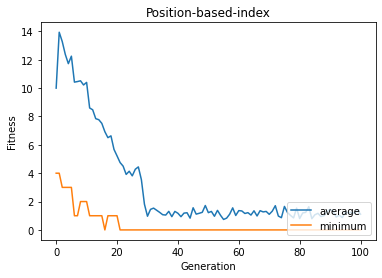

In [19]:
gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Position-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()



### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [38]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is: {}'.format(best_ind))
print('Eval Fitness Value: {}'.format(eval_fitness(best_ind)))
show_grid(best_ind, board_size)


Best individual is: [4, 2, 0, 6, 1, 7, 5, 3]
0
1
2
3
4
5
6
7
Eval Fitness Value: (0,)
-|-|-|-|X|-|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------


## Part II: Row-index-based board representation

In [21]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Each row of the chess row is indexed from 0->7 . we place different queens on different rows initially.  The sequence [ a b c d .... ] means that in $0^{th}$ row, $a^{th}$ column, the queen is present and so on

In [22]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, 0, board_size-1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_int, n=board_size)

In [23]:
toolbox.individual()

[2, 5, 4, 6, 5, 6, 1, 4]

In [24]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [25]:
pop = toolbox.population(n=1000)

print(pop[0])

[6, 1, 3, 5, 2, 3, 1, 7]


In [26]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0] * (board_size * board_size)
    for i in range(len(board)):
        n[board[i] + i * board_size] = 1
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X', end="|")
                else:
                    print('-', end="|")
        print()
        print(dashes)

In [27]:
show_grid(pop[0], board_size)

-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------


### 10 pts:  Write your code in the cell below to define the "evaFitness" function, which return the fitness of any given board

- evaFitness() returns the total number of distinct pairs of queens that attack each other.  

- The following are some test cases you may use to verify the correctness of the evaFitness() function:

 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



## compute_conflicts()
Computes the number of conflicts in a given board using a frequency list representation of the board in linear time row a row-index representation. Based on following method described in the following page: https://towardsdatascience.com/computing-number-of-conflicting-pairs-in-a-n-queen-board-in-linear-time-and-space-complexity-e9554c0e0645

In [28]:
def compute_conflicts(board):
    n = len(board)
    row = [0] * n
    diag_right = [0] * (2 * n)
    diag_left = [0] * (2 * n)
    
    for i in range(n):
        print(i)
        row[board[i]] += 1
        diag_right[board[i] + i] += 1
        diag_left[n - board[i] + i] += 1
    
    conflicts = 0
    for i in range(2 * n):
        if i < n:
            conflicts += (row[i] * (row[i] - 1)) / 2
        conflicts += (diag_right[i] * (diag_right[i] - 1)) / 2
        conflicts += (diag_left[i] * (diag_left[i] - 1)) / 2
    return int(conflicts) 

In [29]:
#list1 = [0, 2, 6, 7, 7, 4, 1, 6]
#list2 = [7, 5, 2, 4, 3, 1, 3, 5]
#list3 = [3, 1, 6, 0, 5, 7, 2, 1]
#list4 = [7, 3, 1, 4, 5, 1, 3, 5]

In [30]:
#fitness function
def eval_fitness(individual):
    conflict = compute_conflicts(individual)
    return (conflict, )

In [31]:
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))

### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [32]:

toolbox.register("evaluate", eval_fitness)


In [33]:

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)



In [34]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)


stats.register("avg", np.mean)
stats.register("min", np.min)



### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change. 

In [35]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
5  	624   	4.339	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2

5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


8  	615   	3.826	1  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
19 	633   	2.279	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
20 	609   	1.713	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3

21 	573   	0.982	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
23 	589   	0.28 	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
24 	617   	0.305	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
26 	631   	0.364	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
27 	567   	0.269	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
29 	603   	0.313	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
31 	603   	0.284	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6

3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
32 	592   	0.323	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4

6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
33 	610   	0.312	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7

4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
34 	582   	0.3  	0  
0
1
2
3
4
5

5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
35 	578   	0.251	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
39 	584   	0.228	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
66 	608   	0

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
67 	597   	0.28 	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3

4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
68 	546   	0.242	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
69 	598   	0.277	0  
0
1
2
3
4
5
6
7
0
1
2

7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
70 	599   	0.297	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
75 	591   	0.311	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
79 	604   	0.286	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
80 	621   	0.303	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3

5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


### 5 pts:  Plot the "avg" and "min" for each generation

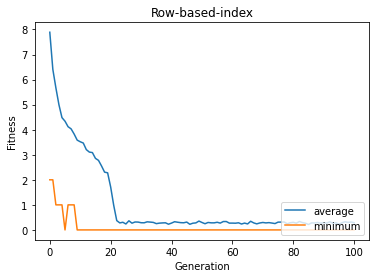

In [36]:
# Plot the "avg" and "min" for each generation

gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Row-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [37]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Number of conflicts:',compute_conflicts(best_ind))
show_grid(best_ind, board_size)


Best individual is: [4, 2, 0, 6, 1, 7, 5, 3]
0
1
2
3
4
5
6
7
Number of conflicts: 0
-|-|-|-|X|-|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------


### Reflection:  Which board representaion is better in terms of ease of coding and final solution quality?   Try different parameter values for mutation and crossover and vary the number of generations and the population size.  Write your findings in the report.        

We believe that row-index representation exceeds position-index representation because we are able to put a constraint on one of the fundamental ways queens may attack each other, reducing our search space by a substantial amount. However, programming an evaluation function for this representation required viewing each queen's conflict as a complete graph, which is a much more complex algorithm than the one written for positional-indexing. In other words, row-index representation is more complex to program, but it also yields higher quality results. 
    
Solution quality:
    Row-index representation